In [20]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('../data/nfp2/nfp2.db')  # Adjust the path to your database file

# Step 2 & 3: Query the database and load the data into a pandas DataFrame
query = "SELECT * FROM stellarators"  # Adjust your query as needed
data_df = pd.read_sql_query(query, conn)

In [21]:
from sklearn.model_selection import train_test_split, GridSearchCV

data_df_clean = data_df.dropna(subset=['quasisymmetry'])

X = data_df_clean[['rbc_1_0', 'rbc_m1_1', 'rbc_0_1', 'rbc_1_1','zbs_1_0', 'zbs_m1_1', 'zbs_0_1', 'zbs_1_1']] 
Y = data_df_clean[['quasisymmetry', 'quasiisodynamic', 'rotational_transform', 'inverse_aspect_ratio', 'mean_local_magnetic_shear', 'vacuum_magnetic_well', 'maximum_elongation', 'mirror_ratio']]

target = Y['quasisymmetry']
features = X

X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.2, random_state=42)

print(features.shape)
print(target.shape)


(272504, 8)
(272504,)


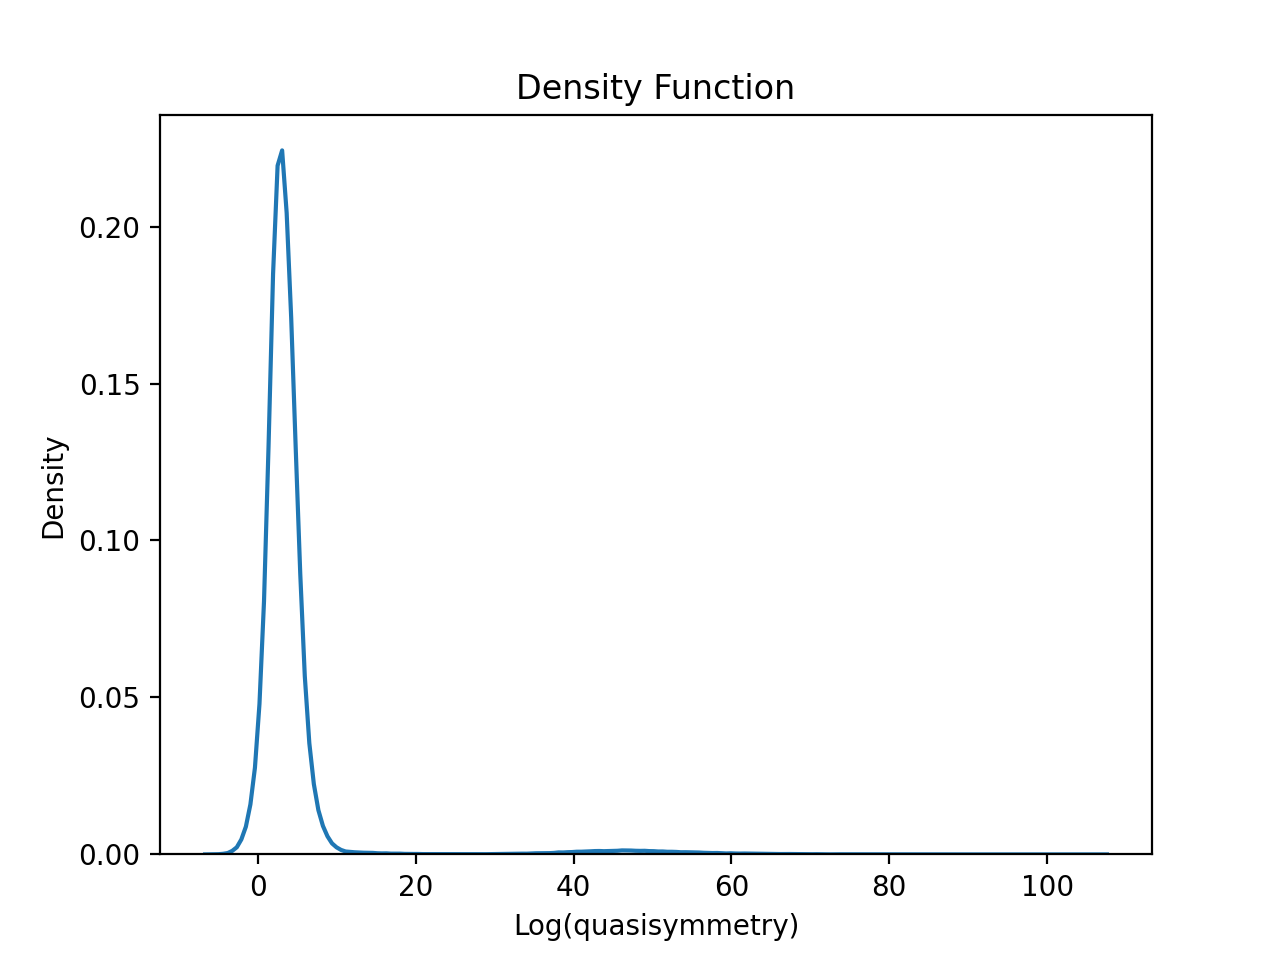

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.kdeplot(np.log(target), bw_adjust=0.5)
plt.title('Density Function')
plt.xlabel('Log(quasisymmetry)')
plt.ylabel('Density')
plt.show()


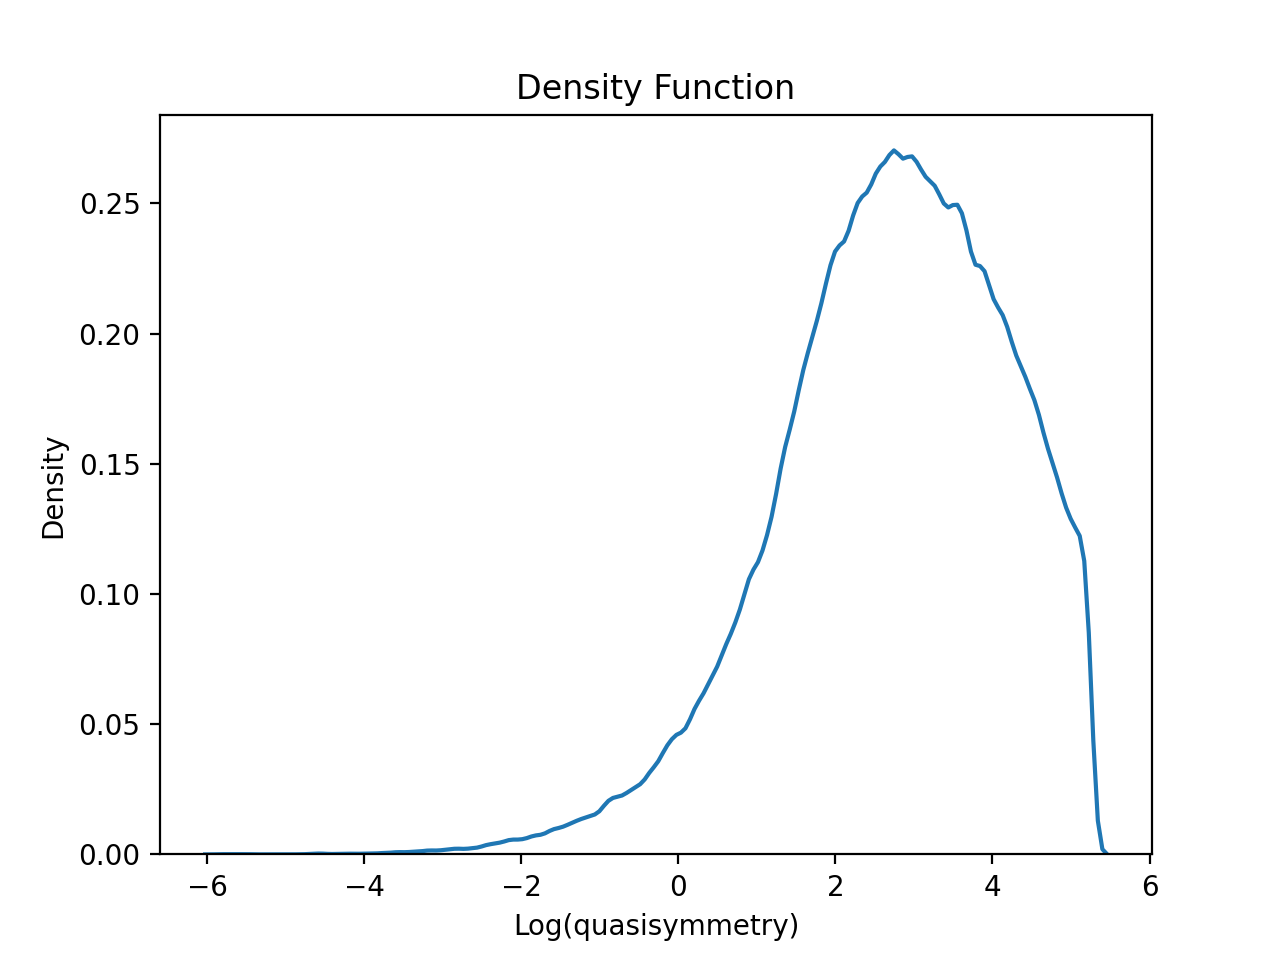

In [23]:
# now i want to eliminate the outliers

q1 = target.quantile(0.25)
q3 = target.quantile(0.75)

# Calculate the interquartile range (IQR)
iqr = q3 - q1

# Define bounds for what is considered an outlier
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter the data to remove outliers
target_no_outliers = Y_train[(Y_train >= lower_bound) & (Y_train <= upper_bound)]
features_no_outliers = X_train.loc[target_no_outliers.index]

sns.kdeplot(np.log(target_no_outliers), bw_adjust=0.5)
plt.title('Density Function')
plt.xlabel('Log(quasisymmetry)')
plt.ylabel('Density')
plt.show()

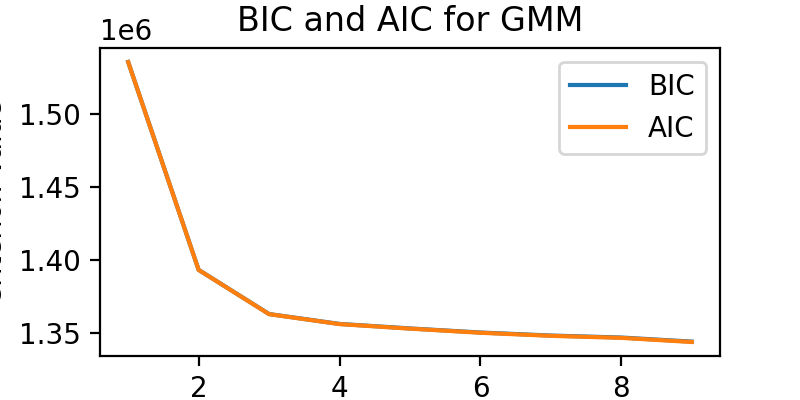

Selected Model Components: 9


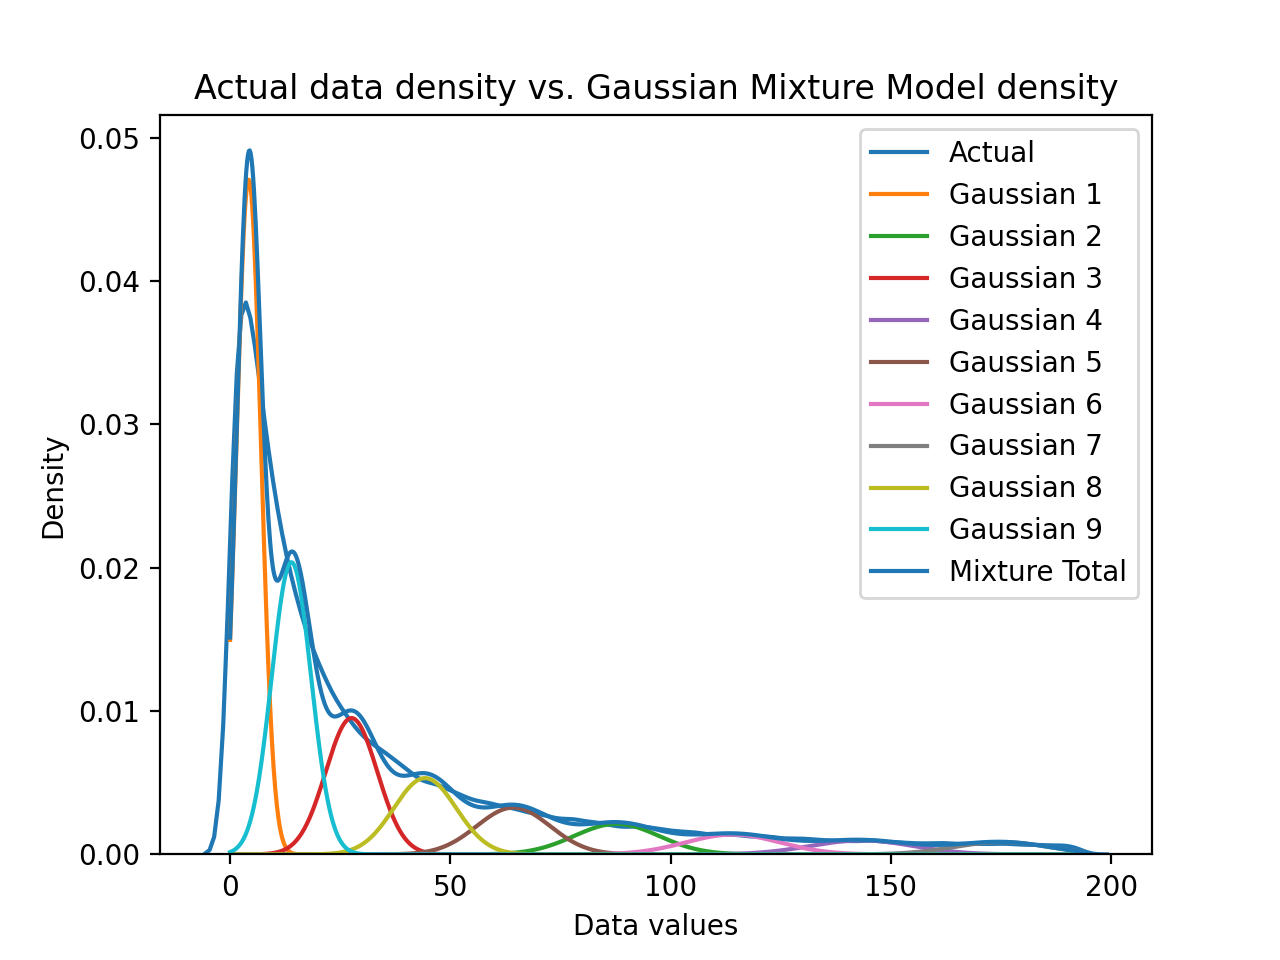

In [24]:
from sklearn.mixture import GaussianMixture

from scipy.stats import norm

X_train, X_test, Y_train, Y_test = train_test_split(features_no_outliers, target_no_outliers, test_size=0.2, random_state=42)


# Assuming `Y_train_np` is your 1D numpy array data
Y_train_np = Y_train.to_numpy().reshape(-1, 1)  # Reshape to 2D if necessary

# Use AIC and BIC to determine the best number of components for GMM
n_components_range = range(1, 10)  # Example range, can be adjusted
lowest_bic = np.infty
lowest_aic = np.infty
best_gmm = None
bic = []
aic = []

for n_components in n_components_range:
    # Fit a Gaussian mixture with n components
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    gmm.fit(Y_train_np)
    
    # Calculate the BIC and AIC
    bic.append(gmm.bic(Y_train_np))
    aic.append(gmm.aic(Y_train_np))
    
    # Determine if this model has the lowest BIC
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_gmm_bic = gmm
        
    # Determine if this model has the lowest AIC
    if aic[-1] < lowest_aic:
        lowest_aic = aic[-1]
        best_gmm_aic = gmm

# Plot the BIC scores
plt.figure(figsize=(4, 2))
plt.plot(n_components_range, bic, label='BIC')
plt.plot(n_components_range, aic, label='AIC')
plt.legend()
plt.xlabel('Number of Components')
plt.ylabel('Criterion Value')
plt.title('BIC and AIC for GMM')
plt.show()

# Use the best model for the final density plot
best_gmm = best_gmm_bic if lowest_bic < lowest_aic else best_gmm_aic
print(f"Selected Model Components: {best_gmm.n_components}")

# Generate some data points for plotting the density
x = np.linspace(Y_train_np.min(), Y_train_np.max(), 1000).reshape(-1, 1)
logprob = best_gmm.score_samples(x)
responsibilities = best_gmm.predict_proba(x)
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

# Plot the actual kernel density estimation of your data
sns.kdeplot(Y_train_np.flatten(), bw_adjust=0.5, label='Actual')

# Plot each component density
for i in range(best_gmm.n_components):
    plt.plot(x, pdf_individual[:, i], label=f'Gaussian {i+1}')

# Plot the total density
plt.plot(x, pdf, label='Mixture Total')

plt.legend()
plt.title('Actual data density vs. Gaussian Mixture Model density')
plt.xlabel('Data values')
plt.ylabel('Density')
plt.show()


Fitting of candidate distributions completed: 100%|██████████| 8/8 [00:23<00:00,  2.93s/it]


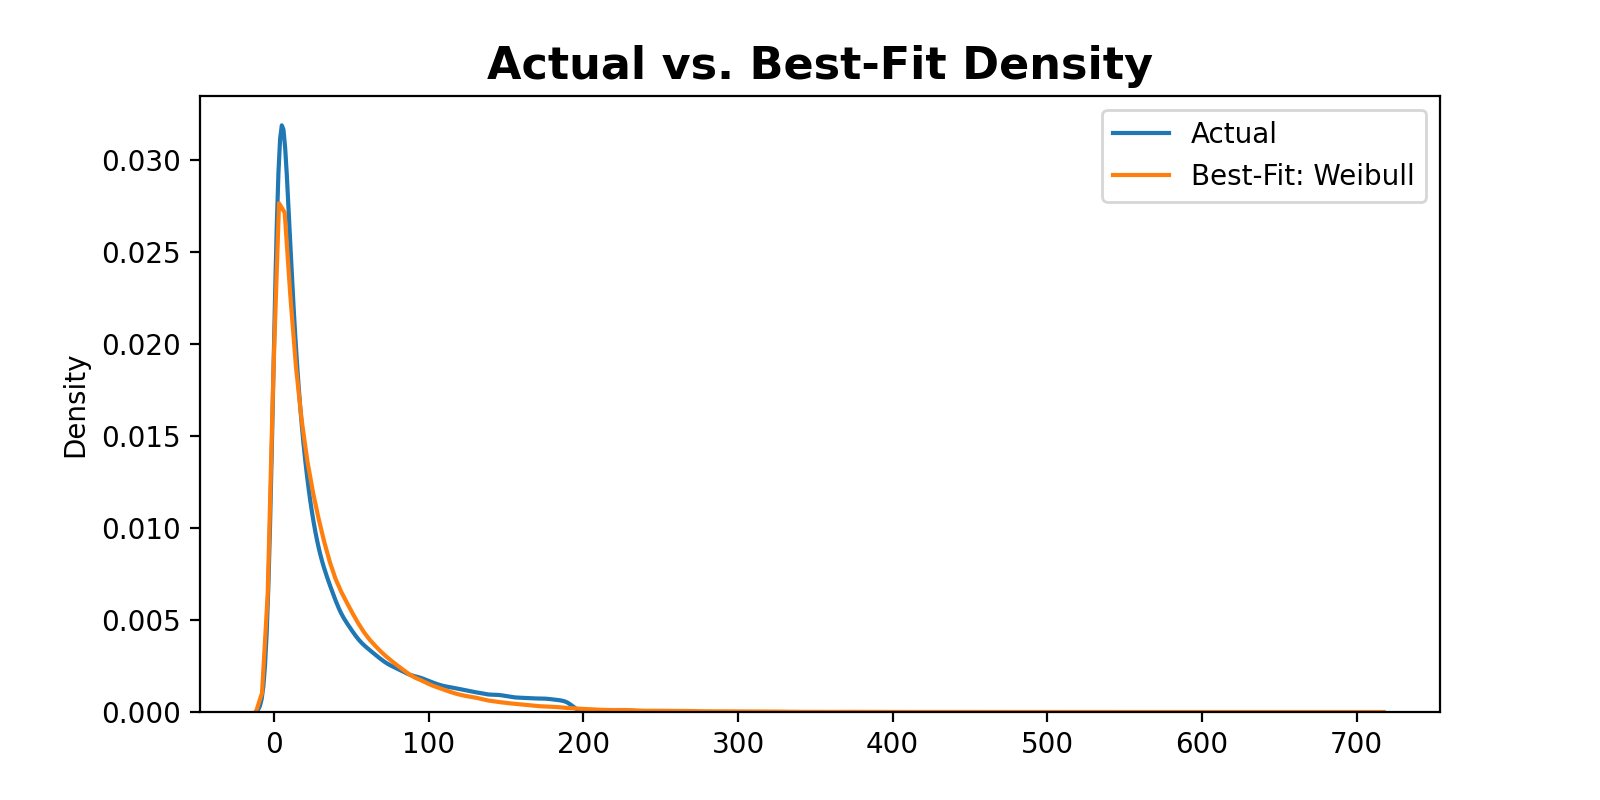

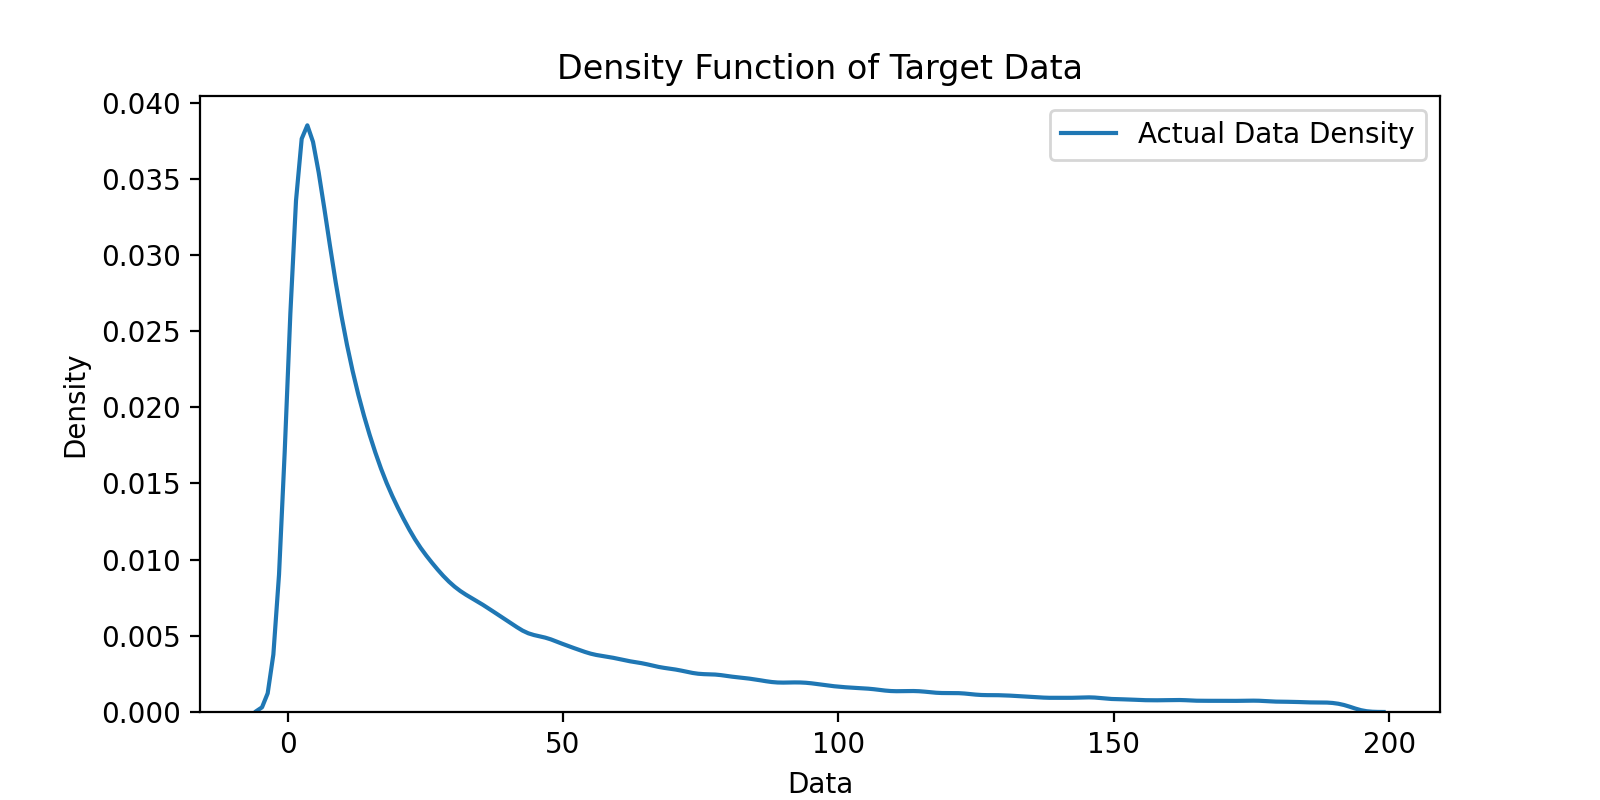

In [25]:
from lightgbmlss.distributions import *
from lightgbmlss.distributions.distribution_utils import DistributionClass
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Your data preparation steps
Y_train_np = np.array(Y_train)

lgblss_dist_class = DistributionClass()
candidate_distributions = [Gaussian, StudentT, Gamma, Cauchy, LogNormal, Weibull, Gumbel, Laplace]

# Selecting the best distribution based on negative log-likelihood
dist_nll = lgblss_dist_class.dist_select(target=Y_train_np, candidate_distributions=candidate_distributions, max_iter=50, plot=True, figure_size=(8, 4))
dist_nll

# Plot the actual data density
plt.figure(figsize=(8, 4))
sns.kdeplot(Y_train_np, bw_adjust=0.5, label='Actual Data Density')
plt.title('Density Function of Target Data')
plt.xlabel('Data')
plt.ylabel('Density')
plt.legend()
plt.show()


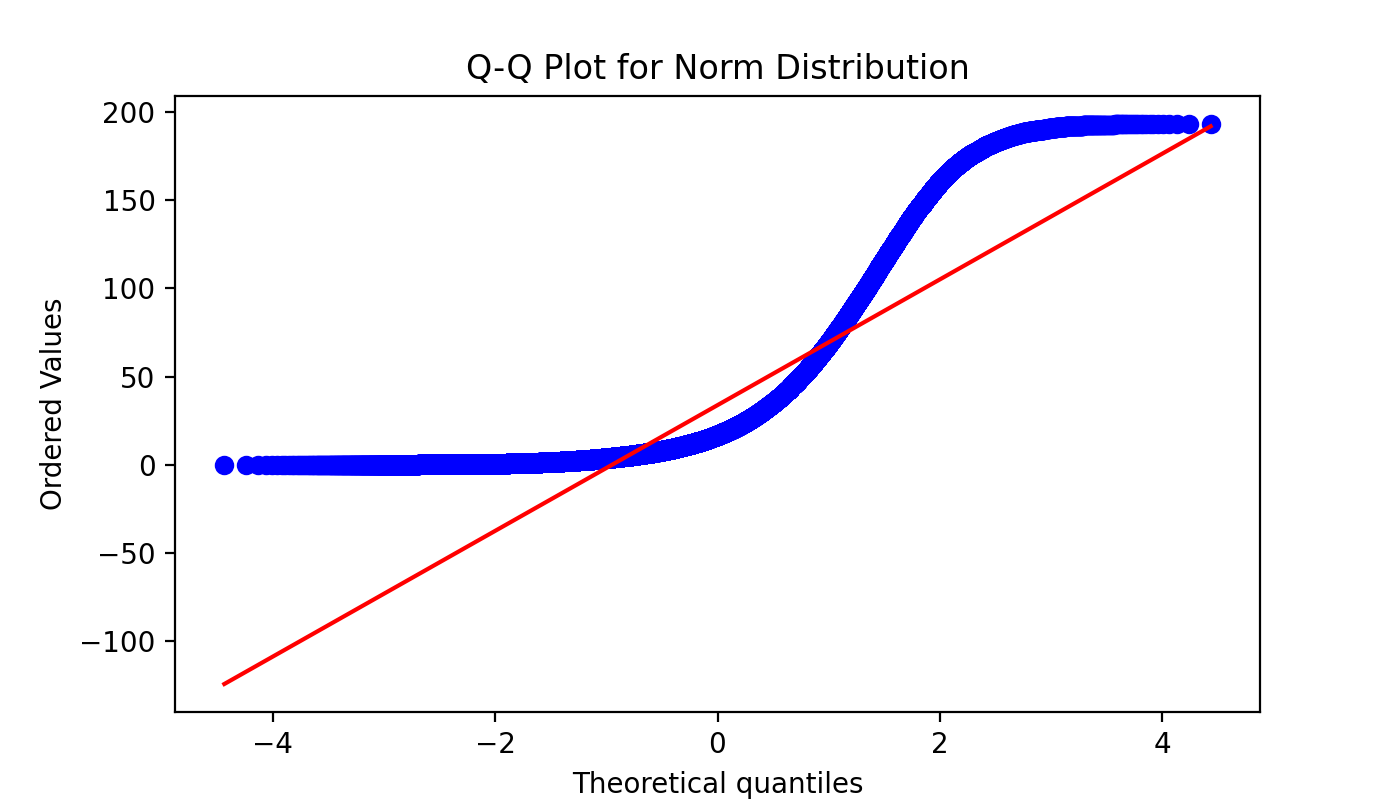

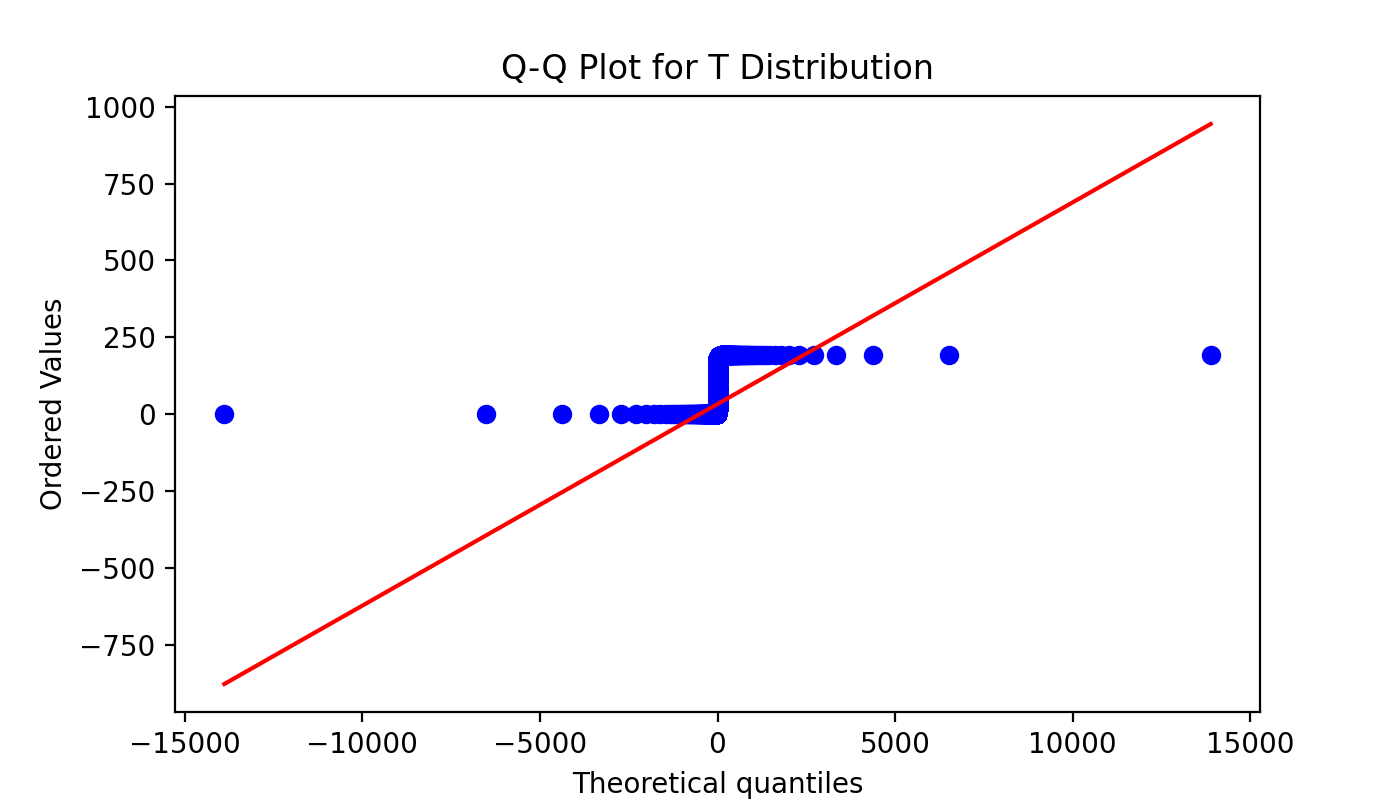

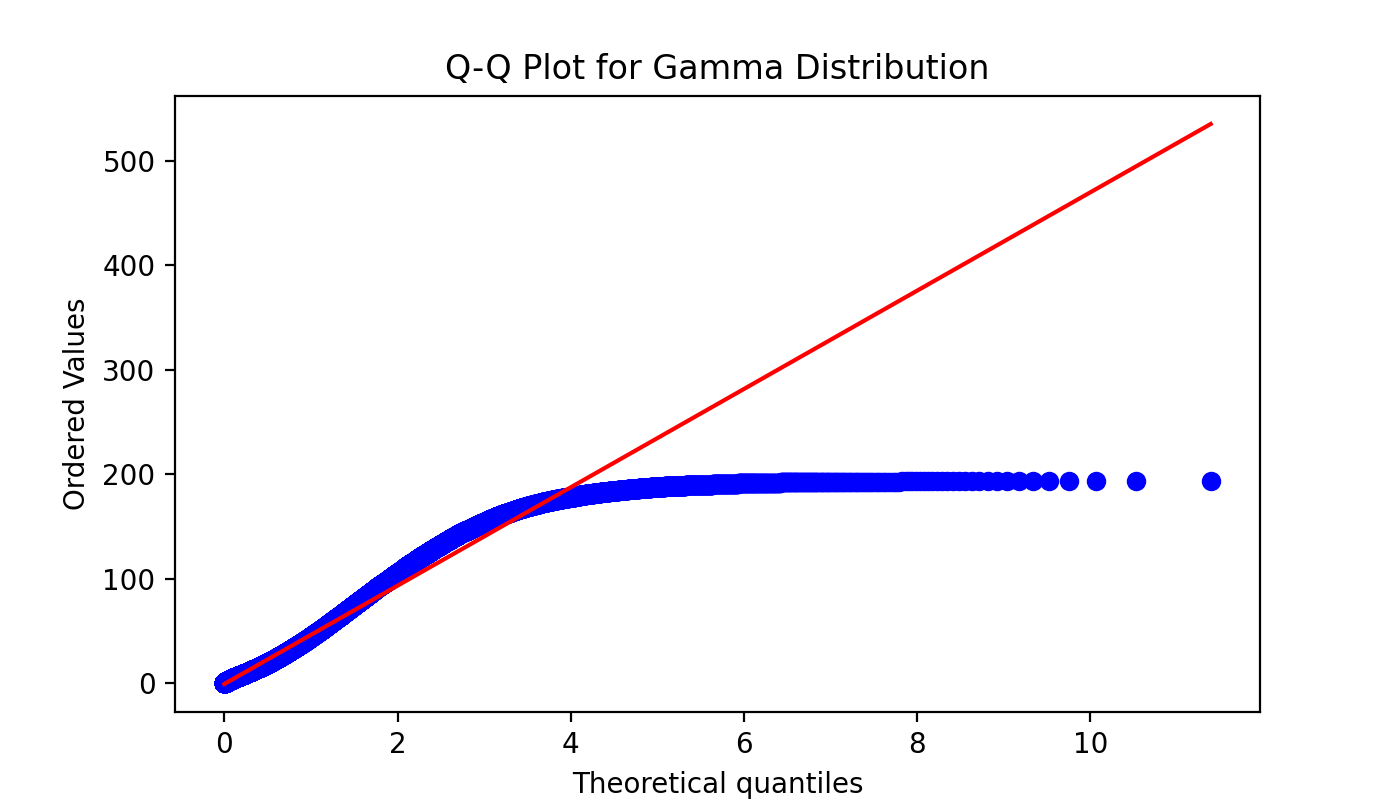

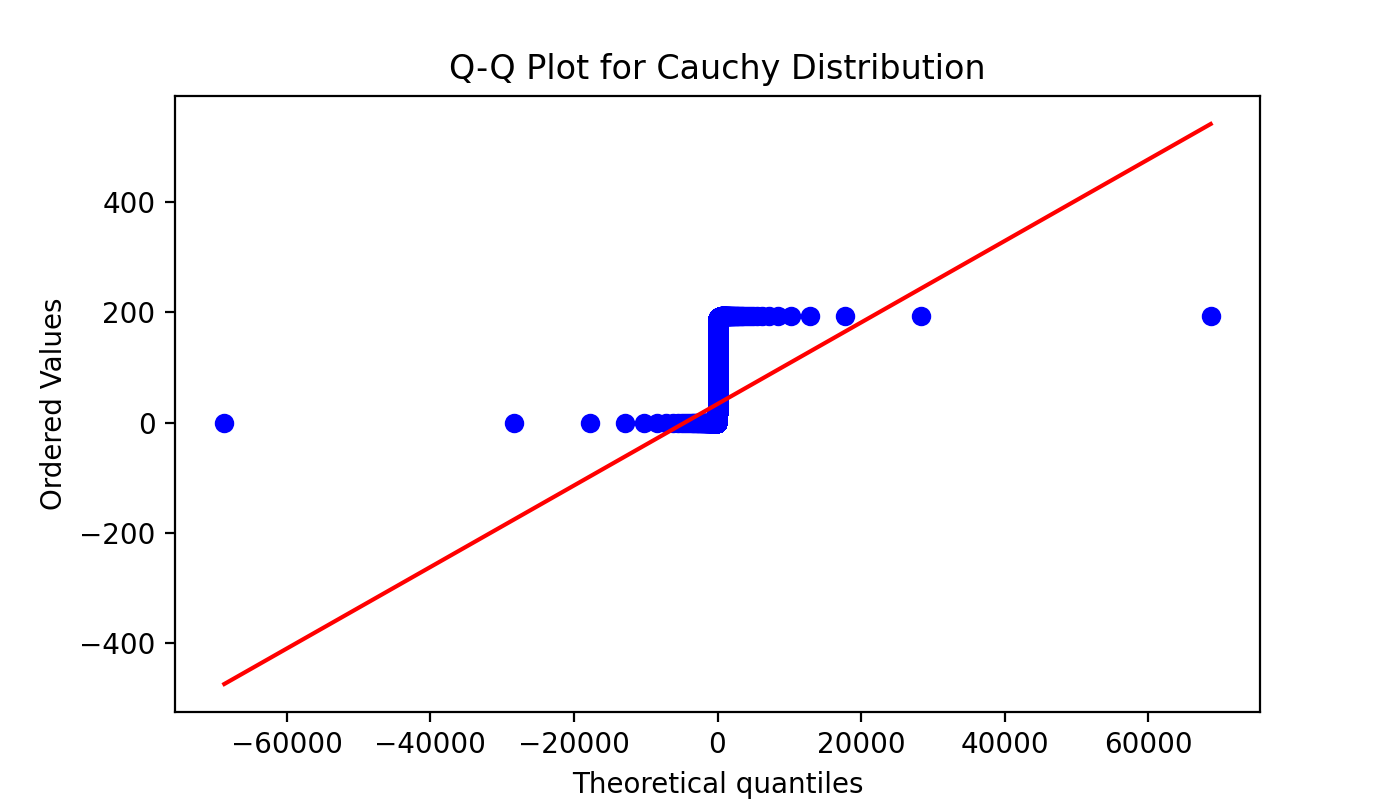

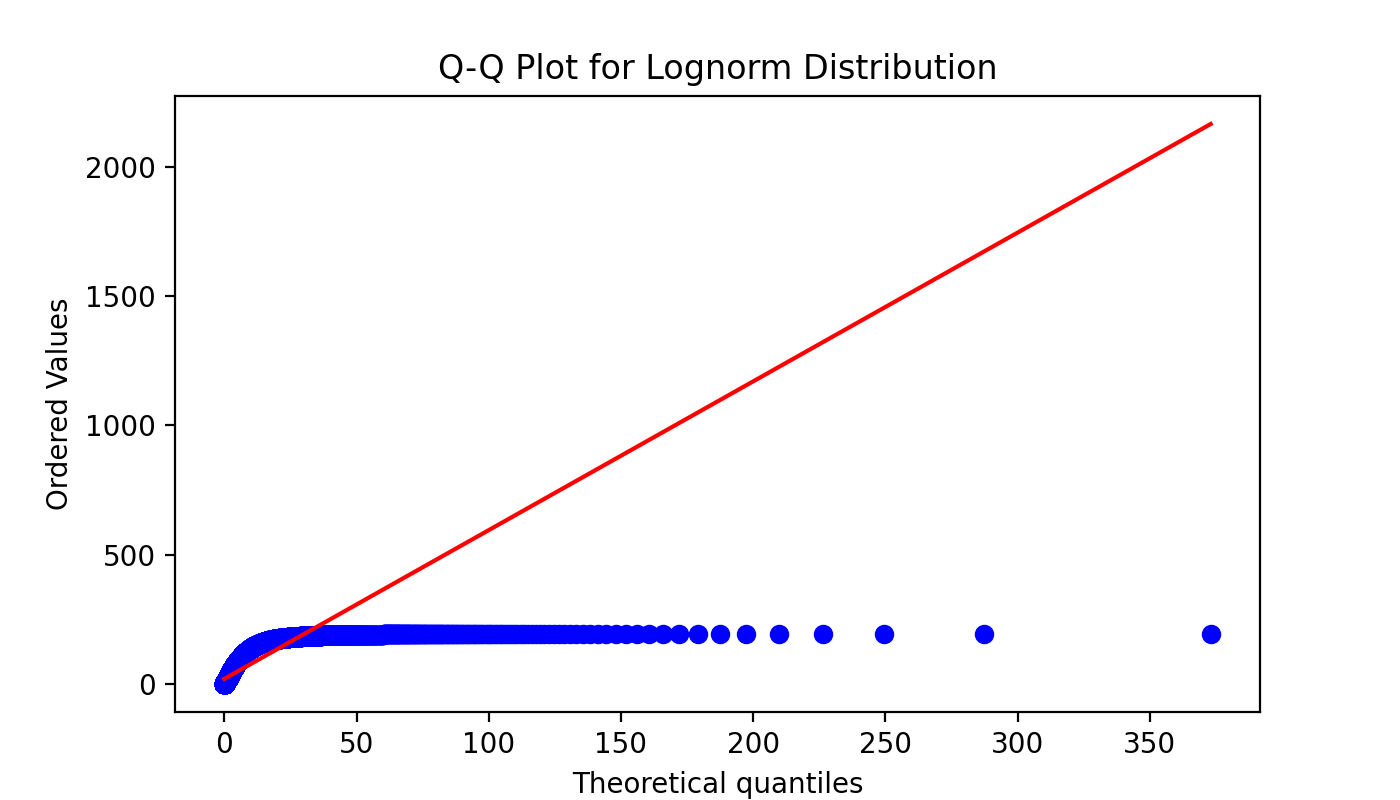

In [26]:
from scipy import stats
import matplotlib.pyplot as plt

# Assuming Y_train_np is your data
distributions = {
    'norm': stats.norm, 
    't': stats.t, 
    'gamma': stats.gamma, 
    'cauchy': stats.cauchy, 
    'lognorm': stats.lognorm,
}

for name, dist in distributions.items():
    # Fit the distribution to your data
    params = dist.fit(Y_train_np)
    
    # Generate Q-Q plot
    plt.figure(figsize=(7, 4))
    stats.probplot(Y_train_np, dist=name, sparams=params[:-2], plot=plt)
    plt.title(f'Q-Q Plot for {name.capitalize()} Distribution')
    plt.show()


este grafico apenas ve a distribuição da target variable?

In [27]:
from lightgbmlss.model import *
from lightgbmlss.distributions.Weibull import *
import lightgbm as lgb
import numpy as np

# Create the Dataset with max_bin parameter specified
dtrain = lgb.Dataset(X_train, label=Y_train.values, params={'max_bin': 500})

# Initialize the LightGBMLSS model with the Weibull distribution
lgblss = LightGBMLSS(
    Weibull(stabilization="None", response_fn="exp", loss_fn="nll")
)

# Define the parameter dictionary without max_bin
param_dict = {
    "max_depth": ["int", {"low": 1, "high": 25, "log": False}],
    "num_leaves": ["int", {"low": 2, "high": 100, "log": True}],
    "min_data_in_leaf": ["int", {"low": 20, "high": 500, "log": False}],
    "min_gain_to_split": ["float", {"low": 0.01, "high": 40, "log": True}],
    "min_sum_hessian_in_leaf": ["float", {"low": 0.01, "high": 100, "log": True}],
    #"subsample": ["float", {"low": 0.5, "high": 1.0, "log": False}],
    #"subsample_freq": ["int", {"low": 1, "high": 20, "log": False}],
    "feature_fraction": ["float", {"low": 0.3, "high": 1.0, "log": False}],
    "boosting_type": ["categorical", ["dart", "goss", "gbdt"]],
    "learning_rate": ["float", {"low": 0.1, "high": 0.2, "log": True}],
    # "lambda_l1" and "lambda_l2" are commented out as before
    #"max_delta_step": ["float", {"low": 0, "high": 1, "log": False}],
    "num_boost_round": ["int", {"low": 5, "high": 1000, "log": True}],
    "feature_pre_filter": ["categorical", [False]],
    "boosting": ["categorical", ["dart"]]
}

# Set a seed for reproducibility
np.random.seed(123)

# Perform hyperparameter optimization
opt_param = lgblss.hyper_opt(
    param_dict,
    dtrain,
    #num_boost_round=30,
    nfold=5,
    early_stopping_rounds=50,
    #max_minutes=5,
    n_trials=100,
    silence=False,
    seed=13,
    hp_seed=123
)



[I 2024-04-19 01:06:59,924] A new study created in memory with name: LightGBMLSS Hyper-Parameter Optimization
Best trial: 0. Best value: 131974:   1%|          | 1/100 [00:14<24:35, 14.90s/it, 14.90/600 seconds]

[I 2024-04-19 01:07:14,825] Trial 0 finished with value: 131973.8385104755 and parameters: {'max_depth': 18, 'num_leaves': 5, 'min_data_in_leaf': 129, 'min_gain_to_split': 0.967985545750277, 'min_sum_hessian_in_leaf': 7.548764540205035, 'feature_fraction': 0.5961745220871226, 'boosting_type': 'dart', 'learning_rate': 0.13123181482690746, 'num_boost_round': 29, 'feature_pre_filter': False, 'boosting': 'dart'}. Best is trial 0 with value: 131973.8385104755.


Best trial: 1. Best value: 129533:   2%|▏         | 2/100 [03:27<3:14:55, 119.34s/it, 207.35/600 seconds]

[I 2024-04-19 01:10:27,279] Trial 1 finished with value: 129532.59138133339 and parameters: {'max_depth': 19, 'num_leaves': 9, 'min_data_in_leaf': 48, 'min_gain_to_split': 0.27150590961153415, 'min_sum_hessian_in_leaf': 8.95326879195524, 'feature_fraction': 0.42774421131745, 'boosting_type': 'gbdt', 'learning_rate': 0.15522930669999022, 'num_boost_round': 443, 'feature_pre_filter': False, 'boosting': 'dart'}. Best is trial 1 with value: 129532.59138133339.


Best trial: 1. Best value: 129533:   3%|▎         | 3/100 [03:46<1:59:15, 73.77s/it, 226.89/600 seconds] 

[I 2024-04-19 01:10:46,815] Trial 2 finished with value: 131173.6383801241 and parameters: {'max_depth': 19, 'num_leaves': 20, 'min_data_in_leaf': 367, 'min_gain_to_split': 0.1456523118917113, 'min_sum_hessian_in_leaf': 0.2799978022399009, 'feature_fraction': 0.4597842616152689, 'boosting_type': 'goss', 'learning_rate': 0.13506942844761147, 'num_boost_round': 46, 'feature_pre_filter': False, 'boosting': 'dart'}. Best is trial 1 with value: 129532.59138133339.


Best trial: 1. Best value: 129533:   4%|▍         | 4/100 [04:02<1:21:00, 50.63s/it, 242.05/600 seconds]

[I 2024-04-19 01:11:01,972] Trial 3 finished with value: 130923.47321143327 and parameters: {'max_depth': 13, 'num_leaves': 9, 'min_data_in_leaf': 170, 'min_gain_to_split': 0.34335469087949244, 'min_sum_hessian_in_leaf': 37.459040809262824, 'feature_fraction': 0.9609120127427158, 'boosting_type': 'goss', 'learning_rate': 0.12459839476251115, 'num_boost_round': 42, 'feature_pre_filter': False, 'boosting': 'dart'}. Best is trial 1 with value: 129532.59138133339.


Best trial: 1. Best value: 129533:   5%|▌         | 5/100 [04:11<56:46, 35.86s/it, 251.71/600 seconds]  

[I 2024-04-19 01:11:11,635] Trial 4 finished with value: 132368.43327928204 and parameters: {'max_depth': 22, 'num_leaves': 4, 'min_data_in_leaf': 252, 'min_gain_to_split': 35.485054191969105, 'min_sum_hessian_in_leaf': 1.1965765212602313, 'feature_fraction': 0.7290261680340773, 'boosting_type': 'goss', 'learning_rate': 0.14590891218778215, 'num_boost_round': 29, 'feature_pre_filter': False, 'boosting': 'dart'}. Best is trial 1 with value: 129532.59138133339.


Best trial: 1. Best value: 129533:   6%|▌         | 6/100 [04:14<38:44, 24.73s/it, 254.84/600 seconds]

[I 2024-04-19 01:11:14,771] Trial 5 finished with value: 132454.51027972327 and parameters: {'max_depth': 8, 'num_leaves': 9, 'min_data_in_leaf': 347, 'min_gain_to_split': 14.237969686566485, 'min_sum_hessian_in_leaf': 1.1007516621231448, 'feature_fraction': 0.7685196480735905, 'boosting_type': 'gbdt', 'learning_rate': 0.17929589247759992, 'num_boost_round': 7, 'feature_pre_filter': False, 'boosting': 'dart'}. Best is trial 1 with value: 129532.59138133339.


Best trial: 1. Best value: 129533:   7%|▋         | 7/100 [04:44<40:53, 26.39s/it, 284.64/600 seconds]

[I 2024-04-19 01:11:44,567] Trial 6 finished with value: 131831.24992465824 and parameters: {'max_depth': 20, 'num_leaves': 4, 'min_data_in_leaf': 113, 'min_gain_to_split': 1.153517807450915, 'min_sum_hessian_in_leaf': 0.024146270773370455, 'feature_fraction': 0.9197287783925976, 'boosting_type': 'goss', 'learning_rate': 0.1509877891910106, 'num_boost_round': 91, 'feature_pre_filter': False, 'boosting': 'dart'}. Best is trial 1 with value: 129532.59138133339.


Best trial: 1. Best value: 129533:   8%|▊         | 8/100 [04:47<28:47, 18.78s/it, 287.13/600 seconds]

[I 2024-04-19 01:11:47,055] Trial 7 finished with value: 133745.71976540732 and parameters: {'max_depth': 4, 'num_leaves': 3, 'min_data_in_leaf': 354, 'min_gain_to_split': 0.1406746330756132, 'min_sum_hessian_in_leaf': 5.859778259263872, 'feature_fraction': 0.6880682748024405, 'boosting_type': 'goss', 'learning_rate': 0.12811128518100764, 'num_boost_round': 6, 'feature_pre_filter': False, 'boosting': 'dart'}. Best is trial 1 with value: 129532.59138133339.


Best trial: 1. Best value: 129533:   9%|▉         | 9/100 [04:55<23:25, 15.45s/it, 295.24/600 seconds]

[I 2024-04-19 01:11:55,168] Trial 8 finished with value: 132119.57951142555 and parameters: {'max_depth': 8, 'num_leaves': 8, 'min_data_in_leaf': 359, 'min_gain_to_split': 38.4893844113741, 'min_sum_hessian_in_leaf': 0.2652524859887483, 'feature_fraction': 0.8337834696498037, 'boosting_type': 'goss', 'learning_rate': 0.13184805534341415, 'num_boost_round': 17, 'feature_pre_filter': False, 'boosting': 'dart'}. Best is trial 1 with value: 129532.59138133339.


Best trial: 1. Best value: 129533:  10%|█         | 10/100 [05:08<22:04, 14.71s/it, 308.31/600 seconds]

[I 2024-04-19 01:12:08,237] Trial 9 finished with value: 131172.50272277647 and parameters: {'max_depth': 9, 'num_leaves': 13, 'min_data_in_leaf': 340, 'min_gain_to_split': 0.02407069981096153, 'min_sum_hessian_in_leaf': 0.03338718492856314, 'feature_fraction': 0.5253864245278156, 'boosting_type': 'goss', 'learning_rate': 0.180807244924108, 'num_boost_round': 36, 'feature_pre_filter': False, 'boosting': 'dart'}. Best is trial 1 with value: 129532.59138133339.


Best trial: 1. Best value: 129533:  11%|█         | 11/100 [05:17<19:05, 12.87s/it, 317.00/600 seconds]

[I 2024-04-19 01:12:16,925] Trial 10 pruned. Trial was pruned at iteration 20.


Best trial: 11. Best value: 127873:  12%|█▏        | 12/100 [06:42<51:17, 34.97s/it, 402.54/600 seconds]

[I 2024-04-19 01:13:42,407] Trial 11 finished with value: 127872.51946140235 and parameters: {'max_depth': 14, 'num_leaves': 27, 'min_data_in_leaf': 192, 'min_gain_to_split': 0.23640007402475863, 'min_sum_hessian_in_leaf': 85.35741664238773, 'feature_fraction': 0.9977433618570305, 'boosting_type': 'gbdt', 'learning_rate': 0.10106793026040506, 'num_boost_round': 192, 'feature_pre_filter': False, 'boosting': 'dart'}. Best is trial 11 with value: 127872.51946140235.


Best trial: 11. Best value: 127873:  13%|█▎        | 13/100 [07:20<51:49, 35.74s/it, 440.03/600 seconds]

[I 2024-04-19 01:14:19,959] Trial 12 pruned. Trial was pruned at iteration 91.


Best trial: 11. Best value: 127873:  14%|█▍        | 14/100 [07:28<39:26, 27.52s/it, 448.56/600 seconds]

[I 2024-04-19 01:14:28,479] Trial 13 pruned. Trial was pruned at iteration 20.


Best trial: 11. Best value: 127873:  15%|█▌        | 15/100 [07:35<30:17, 21.39s/it, 455.74/600 seconds]

[I 2024-04-19 01:14:35,656] Trial 14 pruned. Trial was pruned at iteration 20.


Best trial: 15. Best value: 127704:  16%|█▌        | 16/100 [09:02<57:37, 41.16s/it, 542.81/600 seconds]

[I 2024-04-19 01:16:02,736] Trial 15 finished with value: 127704.45007216782 and parameters: {'max_depth': 16, 'num_leaves': 19, 'min_data_in_leaf': 94, 'min_gain_to_split': 3.1559125650527995, 'min_sum_hessian_in_leaf': 3.7786324401902953, 'feature_fraction': 0.859113808776292, 'boosting_type': 'dart', 'learning_rate': 0.1609339622667717, 'num_boost_round': 208, 'feature_pre_filter': False, 'boosting': 'dart'}. Best is trial 15 with value: 127704.45007216782.


Best trial: 16. Best value: 126825:  17%|█▋        | 17/100 [10:11<49:44, 35.95s/it, 611.18/600 seconds]  


[I 2024-04-19 01:17:11,071] Trial 16 finished with value: 126825.0468965309 and parameters: {'max_depth': 11, 'num_leaves': 23, 'min_data_in_leaf': 181, 'min_gain_to_split': 3.216798837123326, 'min_sum_hessian_in_leaf': 3.1854780223090584, 'feature_fraction': 0.997453656267874, 'boosting_type': 'dart', 'learning_rate': 0.19471635831799533, 'num_boost_round': 169, 'feature_pre_filter': False, 'boosting': 'dart'}. Best is trial 16 with value: 126825.0468965309.

Hyper-Parameter Optimization successfully finished.
  Number of finished trials:  17
  Best trial:
    Value: 126825.0468965309
    Params: 
    max_depth: 11
    num_leaves: 23
    min_data_in_leaf: 181
    min_gain_to_split: 3.216798837123326
    min_sum_hessian_in_leaf: 3.1854780223090584
    feature_fraction: 0.997453656267874
    boosting_type: dart
    learning_rate: 0.19471635831799533
    num_boost_round: 169
    feature_pre_filter: False
    boosting: dart
    opt_rounds: 168


In [28]:
np.random.seed(123)

opt_params = opt_param.copy()
n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

# Train Model with optimized hyperparameters
lgblss.train(opt_params, dtrain, num_boost_round=n_rounds)

# Set seed for reproducibility
torch.manual_seed(123)

# Number of samples to draw from predicted distribution
n_samples = 3000
quant_sel = [0.05, 0.95] # Quantiles to calculate from predicted distribution

# Sample from predicted distribution
pred_samples = lgblss.predict(X_test,
                              pred_type="samples",
                              n_samples=n_samples,
                              seed=123)

# Calculate quantiles from predicted distribution
pred_quantiles = lgblss.predict(X_test,
                                pred_type="quantiles",
                                n_samples=n_samples,
                                quantiles=quant_sel)

# Return predicted distributional parameters
pred_params = lgblss.predict(X_test,
                             pred_type="parameters")

In [29]:
pred_samples.head()

y_sample0  y_sample1  y_sample2  y_sample3  y_sample4  y_sample5  \
0   14.864150  24.026138  42.381931   8.631942  33.711288   0.439631   
1   11.914497   3.678243   3.549566   0.328683   0.970670  22.573101   
2   73.958138  31.072025   0.538574  25.846746  23.445805  28.181337   
3  105.834641  48.674011  62.006485  20.907215  55.475502   7.834508   
4   27.251190   7.797891  24.788694  25.023598  21.140083  23.687380   

   y_sample6  y_sample7  y_sample8  y_sample9  ...  y_sample2990  \
0   2.408521  41.140018   3.263780  15.635512  ...     11.169940   
1   4.931016   0.004630   1.727088  10.607705  ...      1.201726   
2  53.584682  21.713535  13.590134  79.412498  ...     24.897583   
3  33.948452  18.089043  10.560060  19.699289  ...    150.777374   
4   9.649788   2.100952  20.188593  12.562381  ...     34.013309   

   y_sample2991  y_sample2992  y_sample2993  y_sample2994  y_sample2995  \
0      8.669425      0.832018     13.864999     32.159817     10.725419   
1     16.576138      9.277170     33.635799      1.122886      5.649522   
2    129.061905     63.456795     33.329628     63.763908     86.571457   
3     79.387222     49.643158     71.301529     25.947483     10.021128   
4     25.211826     27.008291     10.109049      7.532357      1.710087   

   y_sample2996  y_sample2997  y_sample2998  y_sample2999  
0     21.547873     11.050241     12.298355      3.826410  
1      1.574205     14.505776     24.997417     16.162584  
2     63.803501     29.532190     16.931578     17.823036  
3    192.646164     34.044773    108.086632    156.577698  
4      0.830499     16.613791      5.287117     16.020472  

[5 rows x 3000 columns]

In [30]:
pred_quantiles.head()

quant_0.05  quant_0.95
0    0.645027   50.524830
1    0.199516   25.983165
2    5.893129  117.627398
3    7.901791  140.259824
4    1.098378   79.828995

In [31]:
pred_params.head()

scale  concentration
0  16.002039       0.924154
1   7.025860       0.819165
2  53.641712       1.376441
3  62.255836       1.415704
4  25.062529       0.955508

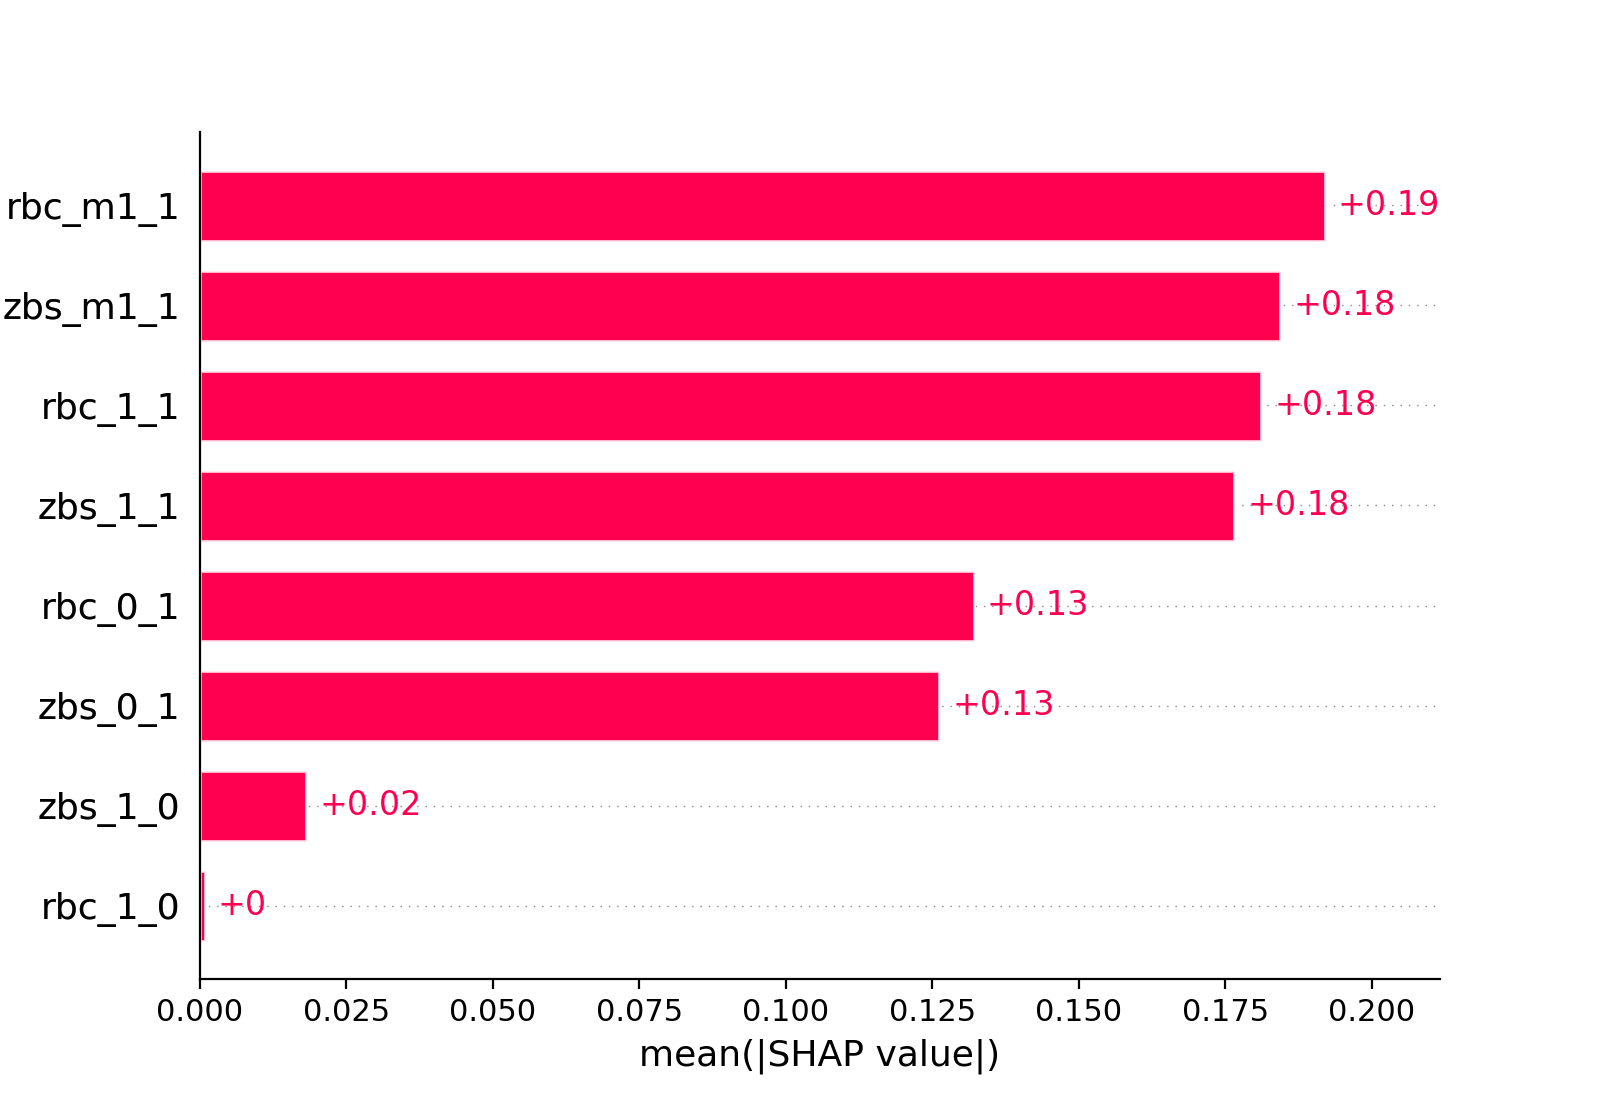

In [32]:
# Feature Importance of scale parameter
lgblss.plot(X_test,
            parameter="scale",
            plot_type="Feature_Importance")

In [33]:

predicted_means = pred_params['concentration']
predicted_variances = pred_params['scale']

# Calculate standard deviation from variance
predicted_std = np.sqrt(predicted_variances)

# Calculate Mean Absolute Error (MAE) as one option for mean error
mean_error = np.mean(np.abs(predicted_means - Y_test))

# For Mean Squared Error (MSE), use:
# mean_squared_error = np.mean((predicted_means - Y_test) ** 2)

# Output the results
print(f"Mean Error (MAE): {mean_error}")
print(f"Standard Deviation: {predicted_std.mean()}")  # Average standard deviation across all predictions

# Note: The calculation of standard deviation's average might need adjustments based on your specific requirements.


Mean Error (MAE): 33.05726900953147
Standard Deviation: 5.342458248138428


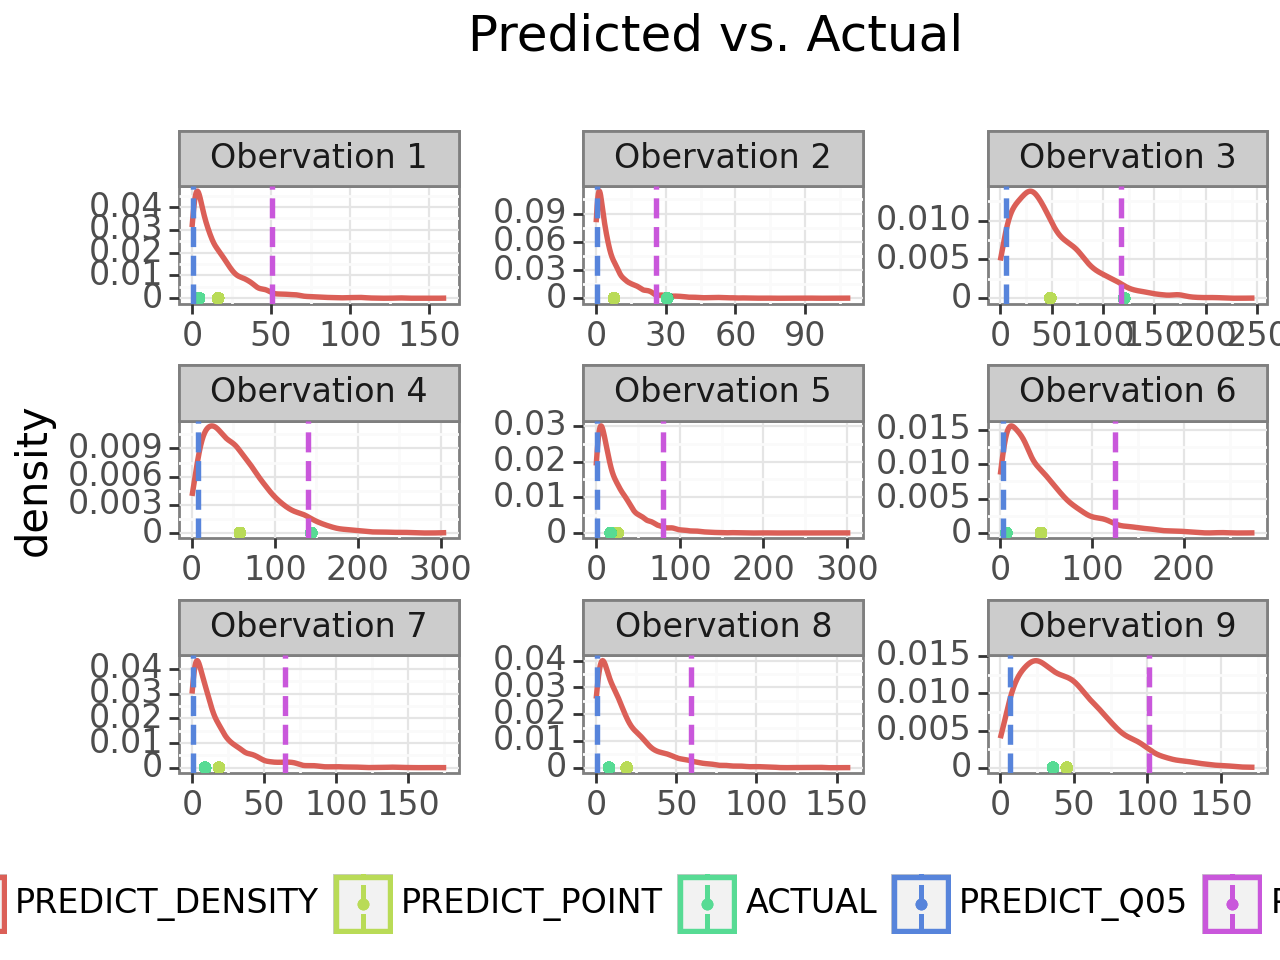

In [34]:
from plotnine import ggplot, aes, geom_point, geom_vline, stat_density, facet_wrap, labs, theme_bw, scale_fill_brewer, theme, element_text, element_blank

y_pred = []

n_examples = 9

for i in range(n_examples):    
    y_samples = pd.DataFrame(pred_samples.values[i,:].reshape(-1,1), columns=["PREDICT_DENSITY"])
    y_samples["PREDICT_POINT"] = y_samples["PREDICT_DENSITY"].mean()
    y_samples["PREDICT_Q05"] = y_samples["PREDICT_DENSITY"].quantile(q=quant_sel[0])
    y_samples["PREDICT_Q95"] = y_samples["PREDICT_DENSITY"].quantile(q=quant_sel[1])
    y_samples["ACTUAL"] = Y_test.iloc[i]
    y_samples["obs"]= f"Obervation {i+1}"
    y_pred.append(y_samples)
    
pred_df = pd.melt(pd.concat(y_pred, axis=0), id_vars="obs")
pred_df["obs"] = pd.Categorical(pred_df["obs"], categories=[f"Obervation {i+1}" for i in range(n_examples)])
df_actual, df_pred_dens, df_pred_point, df_q05, df_q95 = [x for _, x in pred_df.groupby("variable")]

plot_pred = (
    ggplot(pred_df,
           aes(color="variable")) + 
    stat_density(df_pred_dens,
                 aes(x="value"),
                 size=1.1) + 
    geom_point(df_pred_point,
               aes(x="value",
                   y=0),
               size=1.4) + 
    geom_point(df_actual,
               aes(x="value",
                   y=0),
               size=1.4) + 
    geom_vline(df_q05, 
               aes(xintercept="value",
                   fill="variable",
                   color="variable"),
               linetype="dashed",
               size=1.1) + 
    geom_vline(df_q95, 
               aes(xintercept="value",
                   fill="variable",
                   color="variable"),
               linetype="dashed",
               size=1.1) + 
    facet_wrap("obs",
               scales="free",
               ncol=3) + 
    labs(title="Predicted vs. Actual \n",
         x = "") + 
    theme_bw(base_size=15) +
    scale_fill_brewer(type="qual", palette="Dark2") + 
    theme(legend_position="bottom",
          plot_title = element_text(hjust = 0.5),
          legend_title = element_blank()
         )
)

print(plot_pred)

UMAP WITH FEATURES AND MEAN ERROR

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.


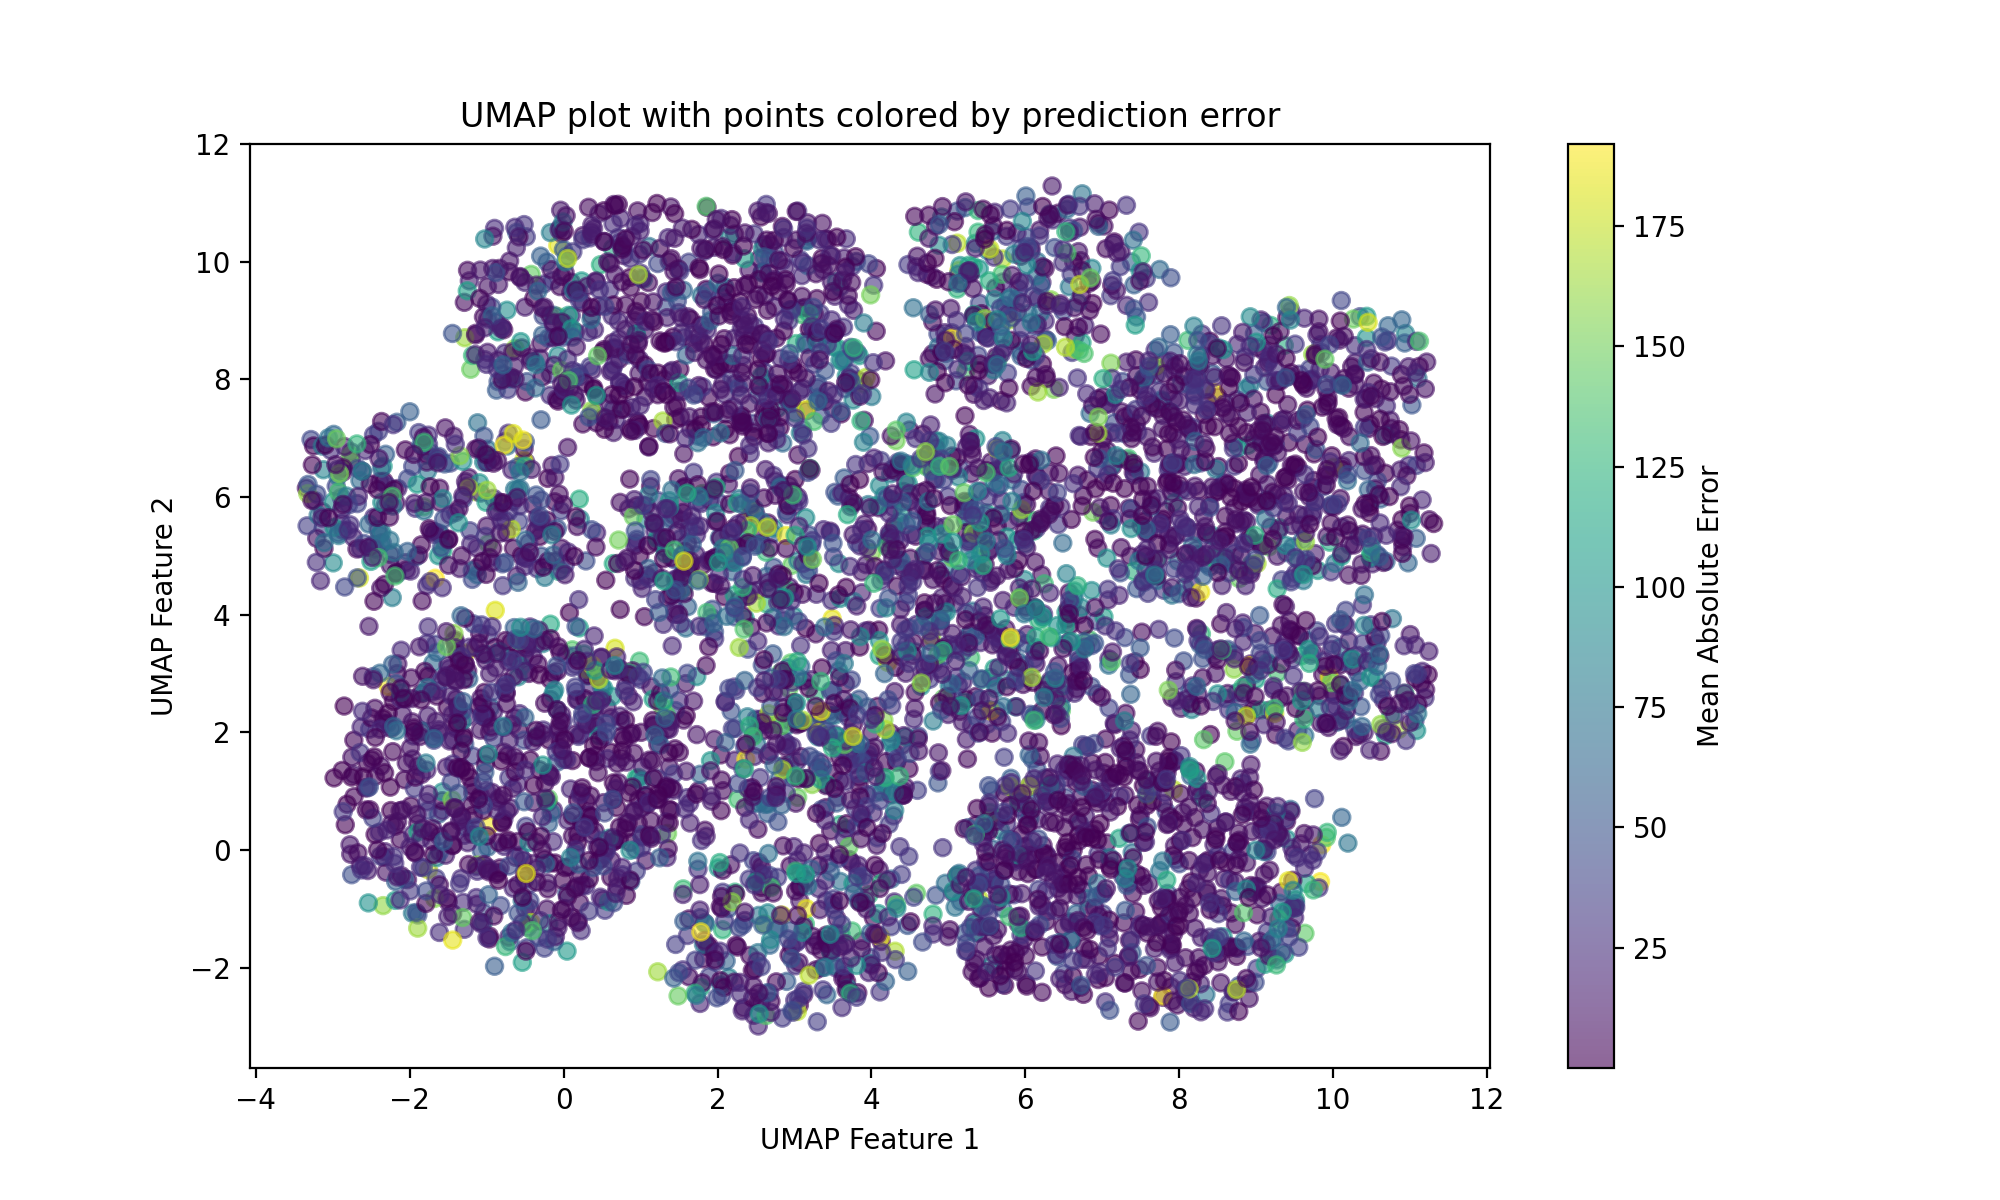

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import umap

# Calculate the absolute error for each prediction
absolute_errors = np.abs(predicted_means - Y_test)

# Combine the features and the errors into one DataFrame for t-SNE/UMAP
tsne_features = X_test.copy()
tsne_features['absolute_error'] = absolute_errors

# Replace inf/-inf with NaN
tsne_features.replace([np.inf, -np.inf], np.nan, inplace=True)

# Option 1: Drop rows with NaNs (if they were inf/-inf)
tsne_features.dropna(inplace=True)


# Initialize UMAP. You can adjust n_neighbors and min_dist as needed.
reducer = umap.UMAP(n_neighbors=200, min_dist=1, n_components=2, random_state=42)

# Fit and transform the features (excluding the 'absolute_error' column)
embedding = reducer.fit_transform(tsne_features.drop('absolute_error', axis=1))

# Now, let's create the plot using UMAP results
plt.figure(figsize=(10,6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                      c=tsne_features['absolute_error'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Mean Absolute Error')
plt.title('UMAP plot with points colored by prediction error')
plt.xlabel('UMAP Feature 1')
plt.ylabel('UMAP Feature 2')
plt.show()


UMAP WITH FEATURES AND STD

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.


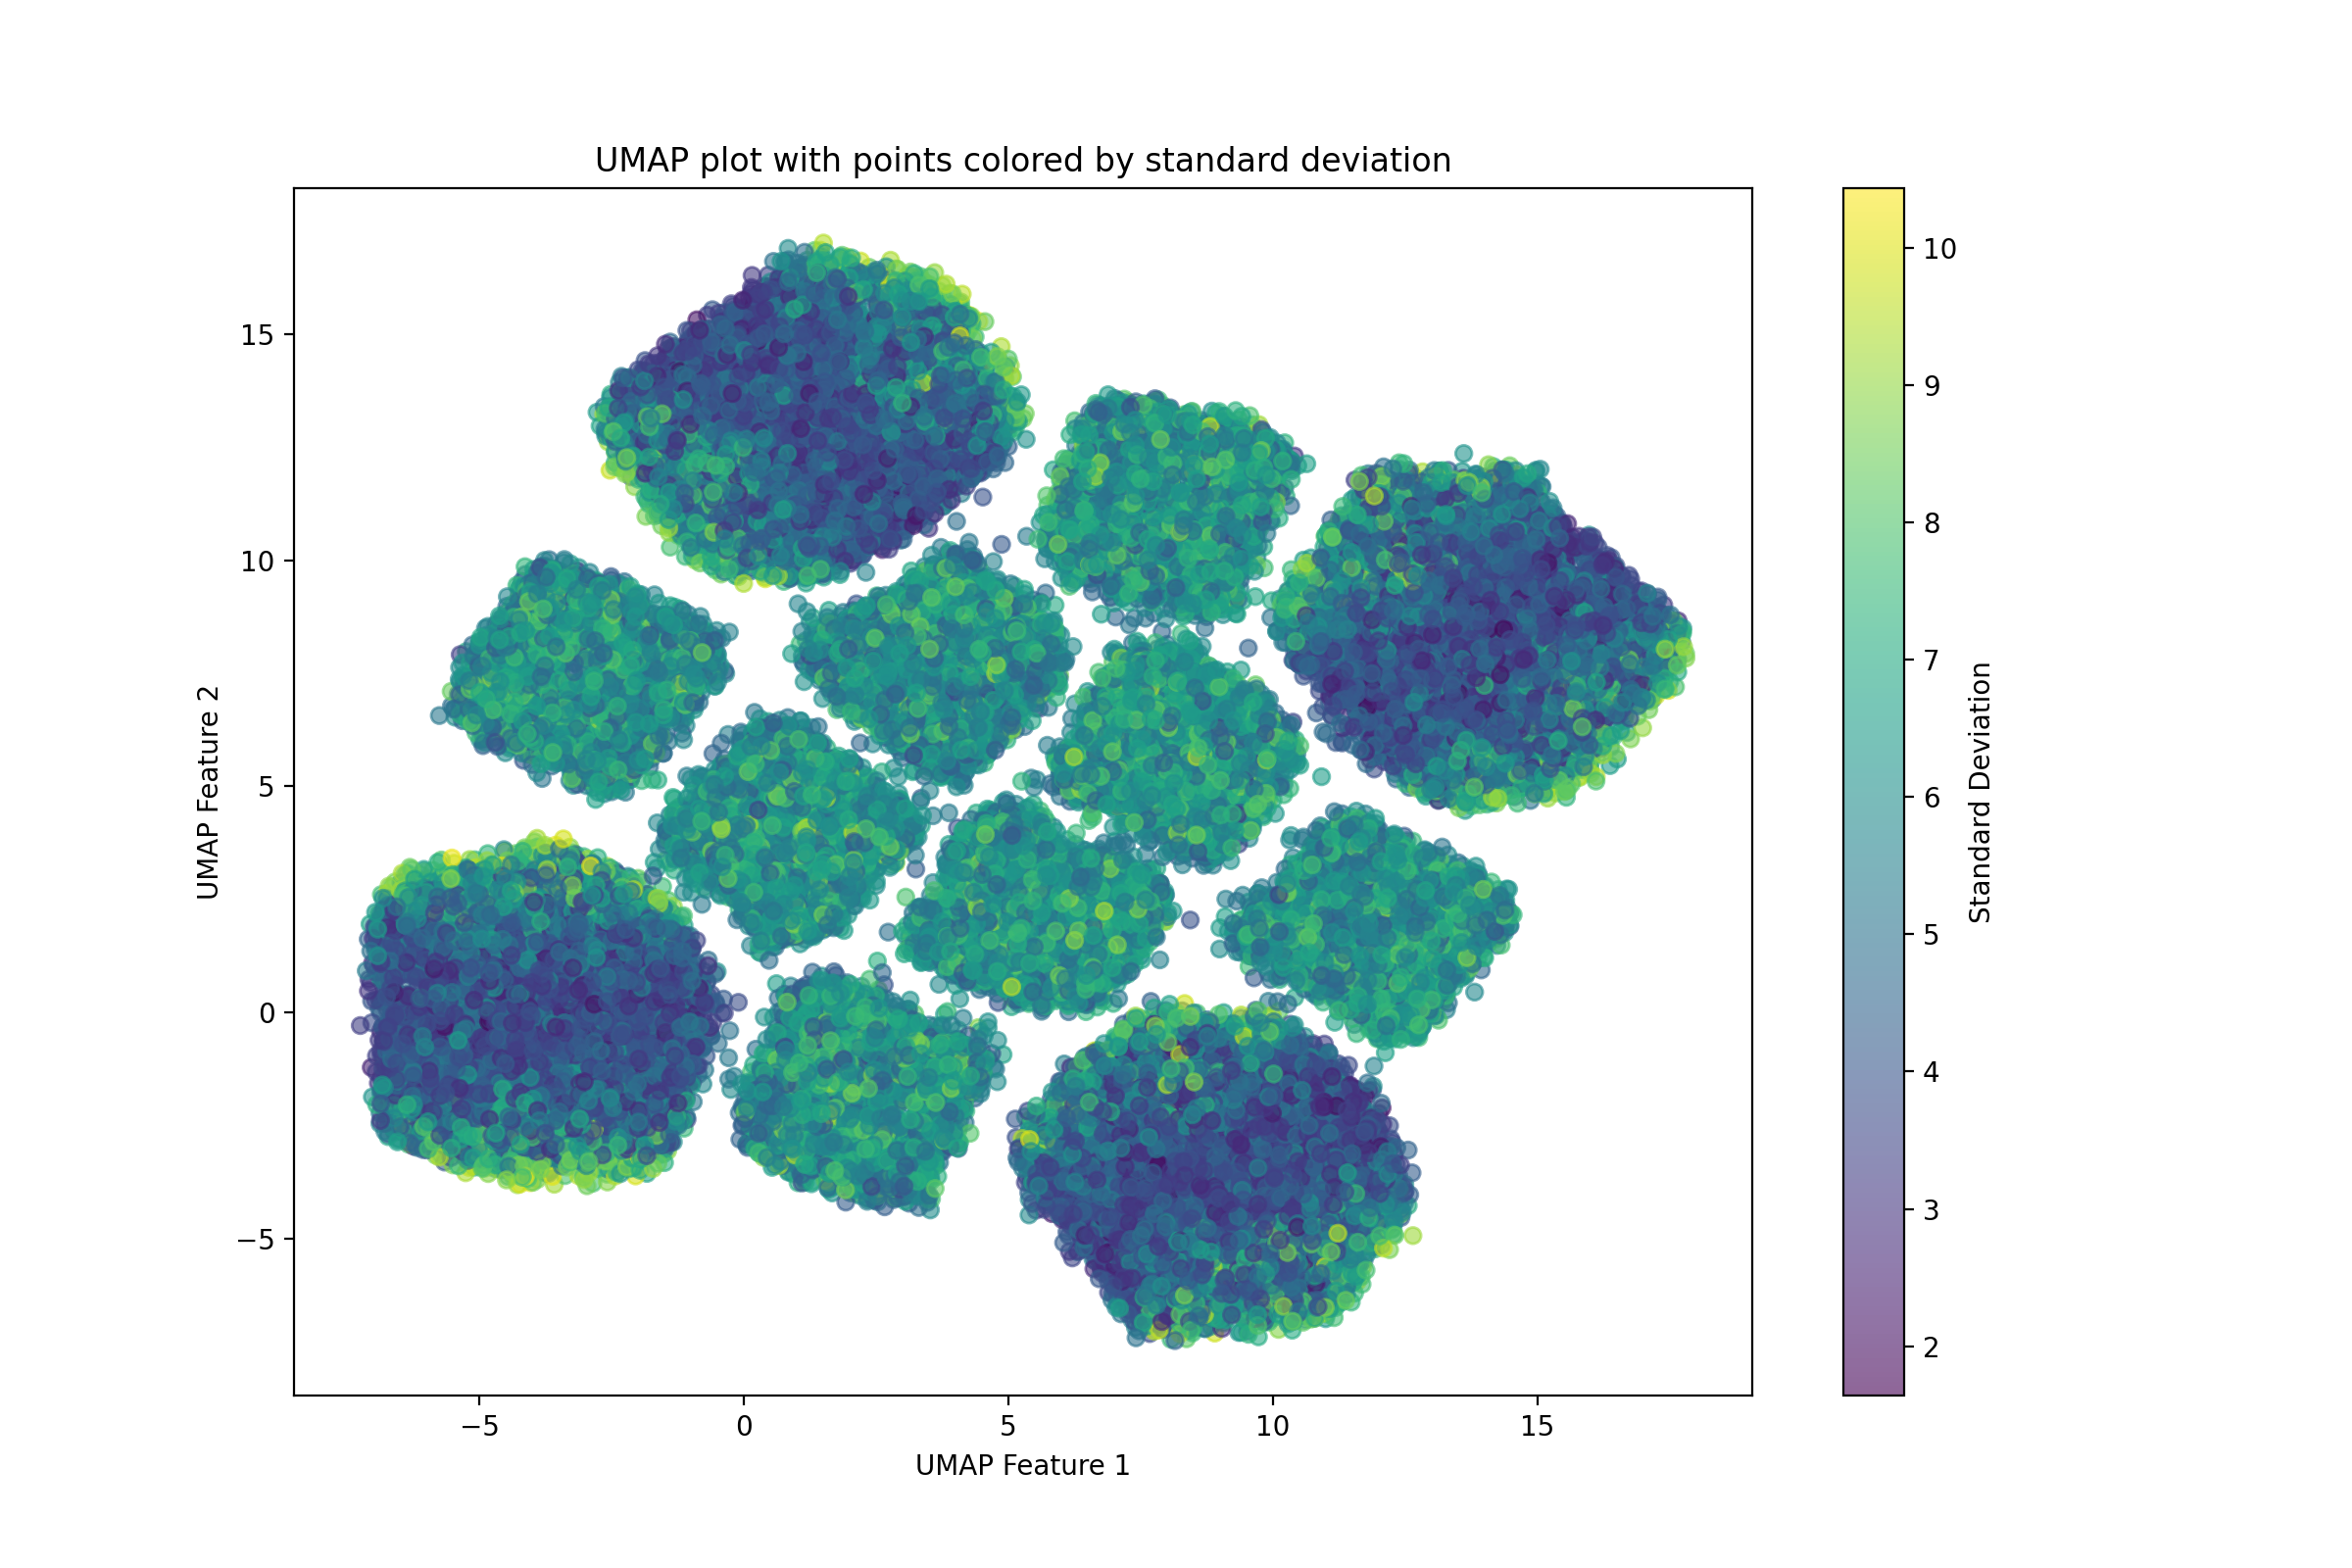

In [36]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import umap.umap_ as umap
import matplotlib.pyplot as plt

# Replace inf/-inf with NaN in your features
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Check if there are any NaN values and handle them
if X_test.isnull().values.any():
    # Impute the NaNs or drop the rows/columns with NaN values.
    # Here we impute with the mean, but you might want to consider other imputation methods
    X_test = X_test.fillna(X_test.mean())

# Ensure no infinite values in predicted_variances before calculating the standard deviation
predicted_variances = np.where(np.isfinite(predicted_variances), predicted_variances, np.nan)
predicted_variances = np.nan_to_num(predicted_variances, nan=np.nanmean(predicted_variances))
predicted_std = np.sqrt(predicted_variances)

# Normalize your features to ensure they don't contain too large values
scaler = MinMaxScaler()
X_test_scaled = scaler.fit_transform(X_test)

# Combine the scaled features and the standard deviations into one DataFrame for UMAP
umap_features = pd.DataFrame(X_test_scaled, columns=X_test.columns)
umap_features['std_dev'] = predicted_std

# Initialize UMAP. You can adjust n_neighbors and min_dist as needed.
reducer = umap.UMAP(n_neighbors=200, min_dist=1, n_components=2, random_state=42)

# Fit and transform the features (excluding the 'std_dev' column)
embedding = reducer.fit_transform(umap_features.drop('std_dev', axis=1))

# Now, let's create the plot using UMAP results
plt.figure(figsize=(12,8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                      c=umap_features['std_dev'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Standard Deviation')
plt.title('UMAP plot with points colored by standard deviation')
plt.xlabel('UMAP Feature 1')
plt.ylabel('UMAP Feature 2')
plt.show()


UMAP WITH TARGET AND MEAN ERROR

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.


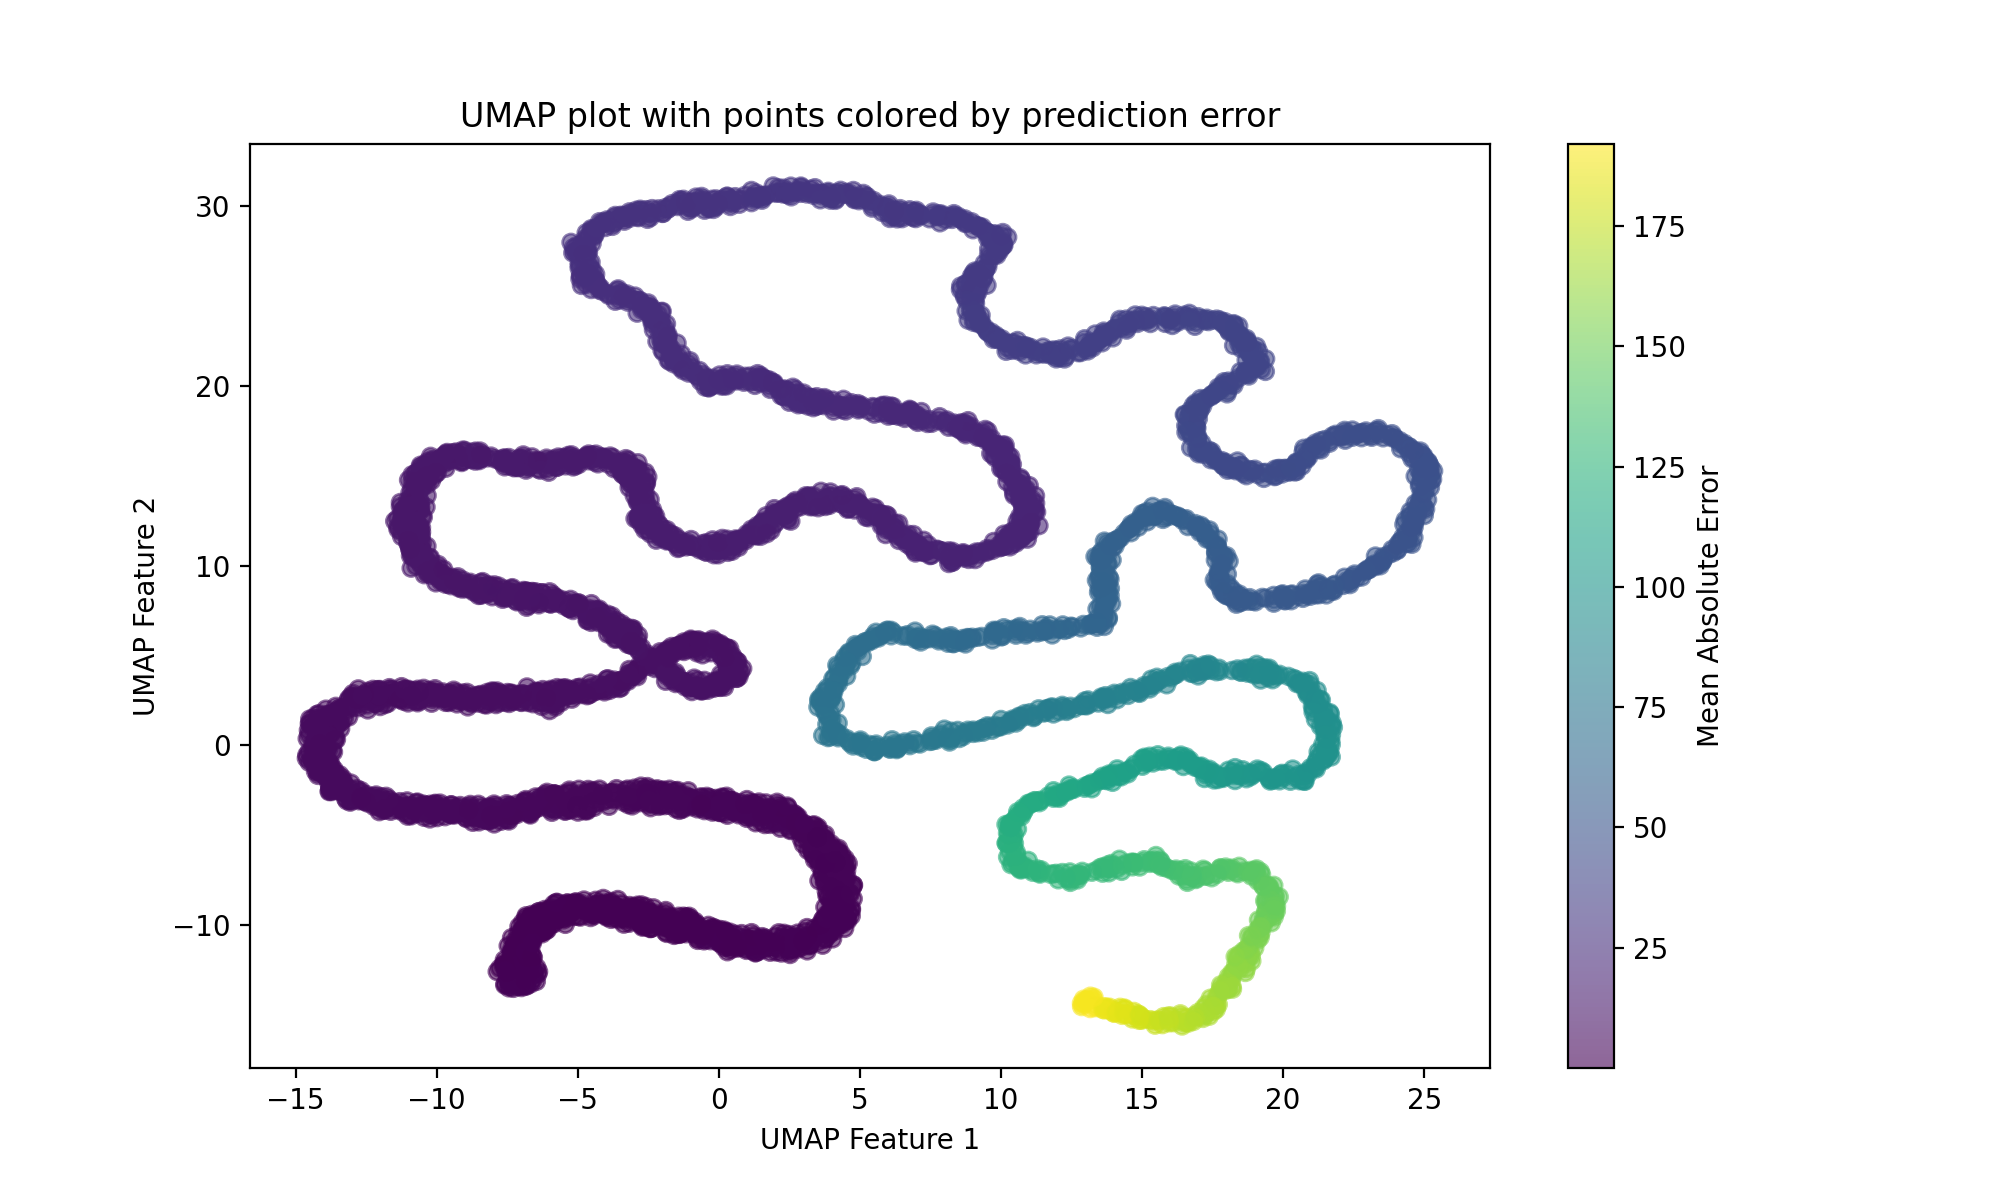

In [37]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import umap

# Calculate the absolute error for each prediction
absolute_errors = np.abs(predicted_means - Y_test)
f_t = pd.concat([X_test, Y_test], axis=1)

# Combine the features and the errors into one DataFrame for t-SNE/UMAP
tsne_features = f_t.copy()
tsne_features['absolute_error'] = absolute_errors

# Replace inf/-inf with NaN
tsne_features.replace([np.inf, -np.inf], np.nan, inplace=True)

# Option 1: Drop rows with NaNs (if they were inf/-inf)
tsne_features.dropna(inplace=True)


# Initialize UMAP. You can adjust n_neighbors and min_dist as needed.
reducer = umap.UMAP(n_neighbors=200, min_dist=1, n_components=2, random_state=42)

# Fit and transform the features (excluding the 'absolute_error' column)
embedding = reducer.fit_transform(tsne_features.drop('absolute_error', axis=1))

# Now, let's create the plot using UMAP results
plt.figure(figsize=(10,6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                      c=tsne_features['absolute_error'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Mean Absolute Error')
plt.title('UMAP plot with points colored by prediction error')
plt.xlabel('UMAP Feature 1')
plt.ylabel('UMAP Feature 2')
plt.show()


UMAP WITH TARGET AND STD

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.


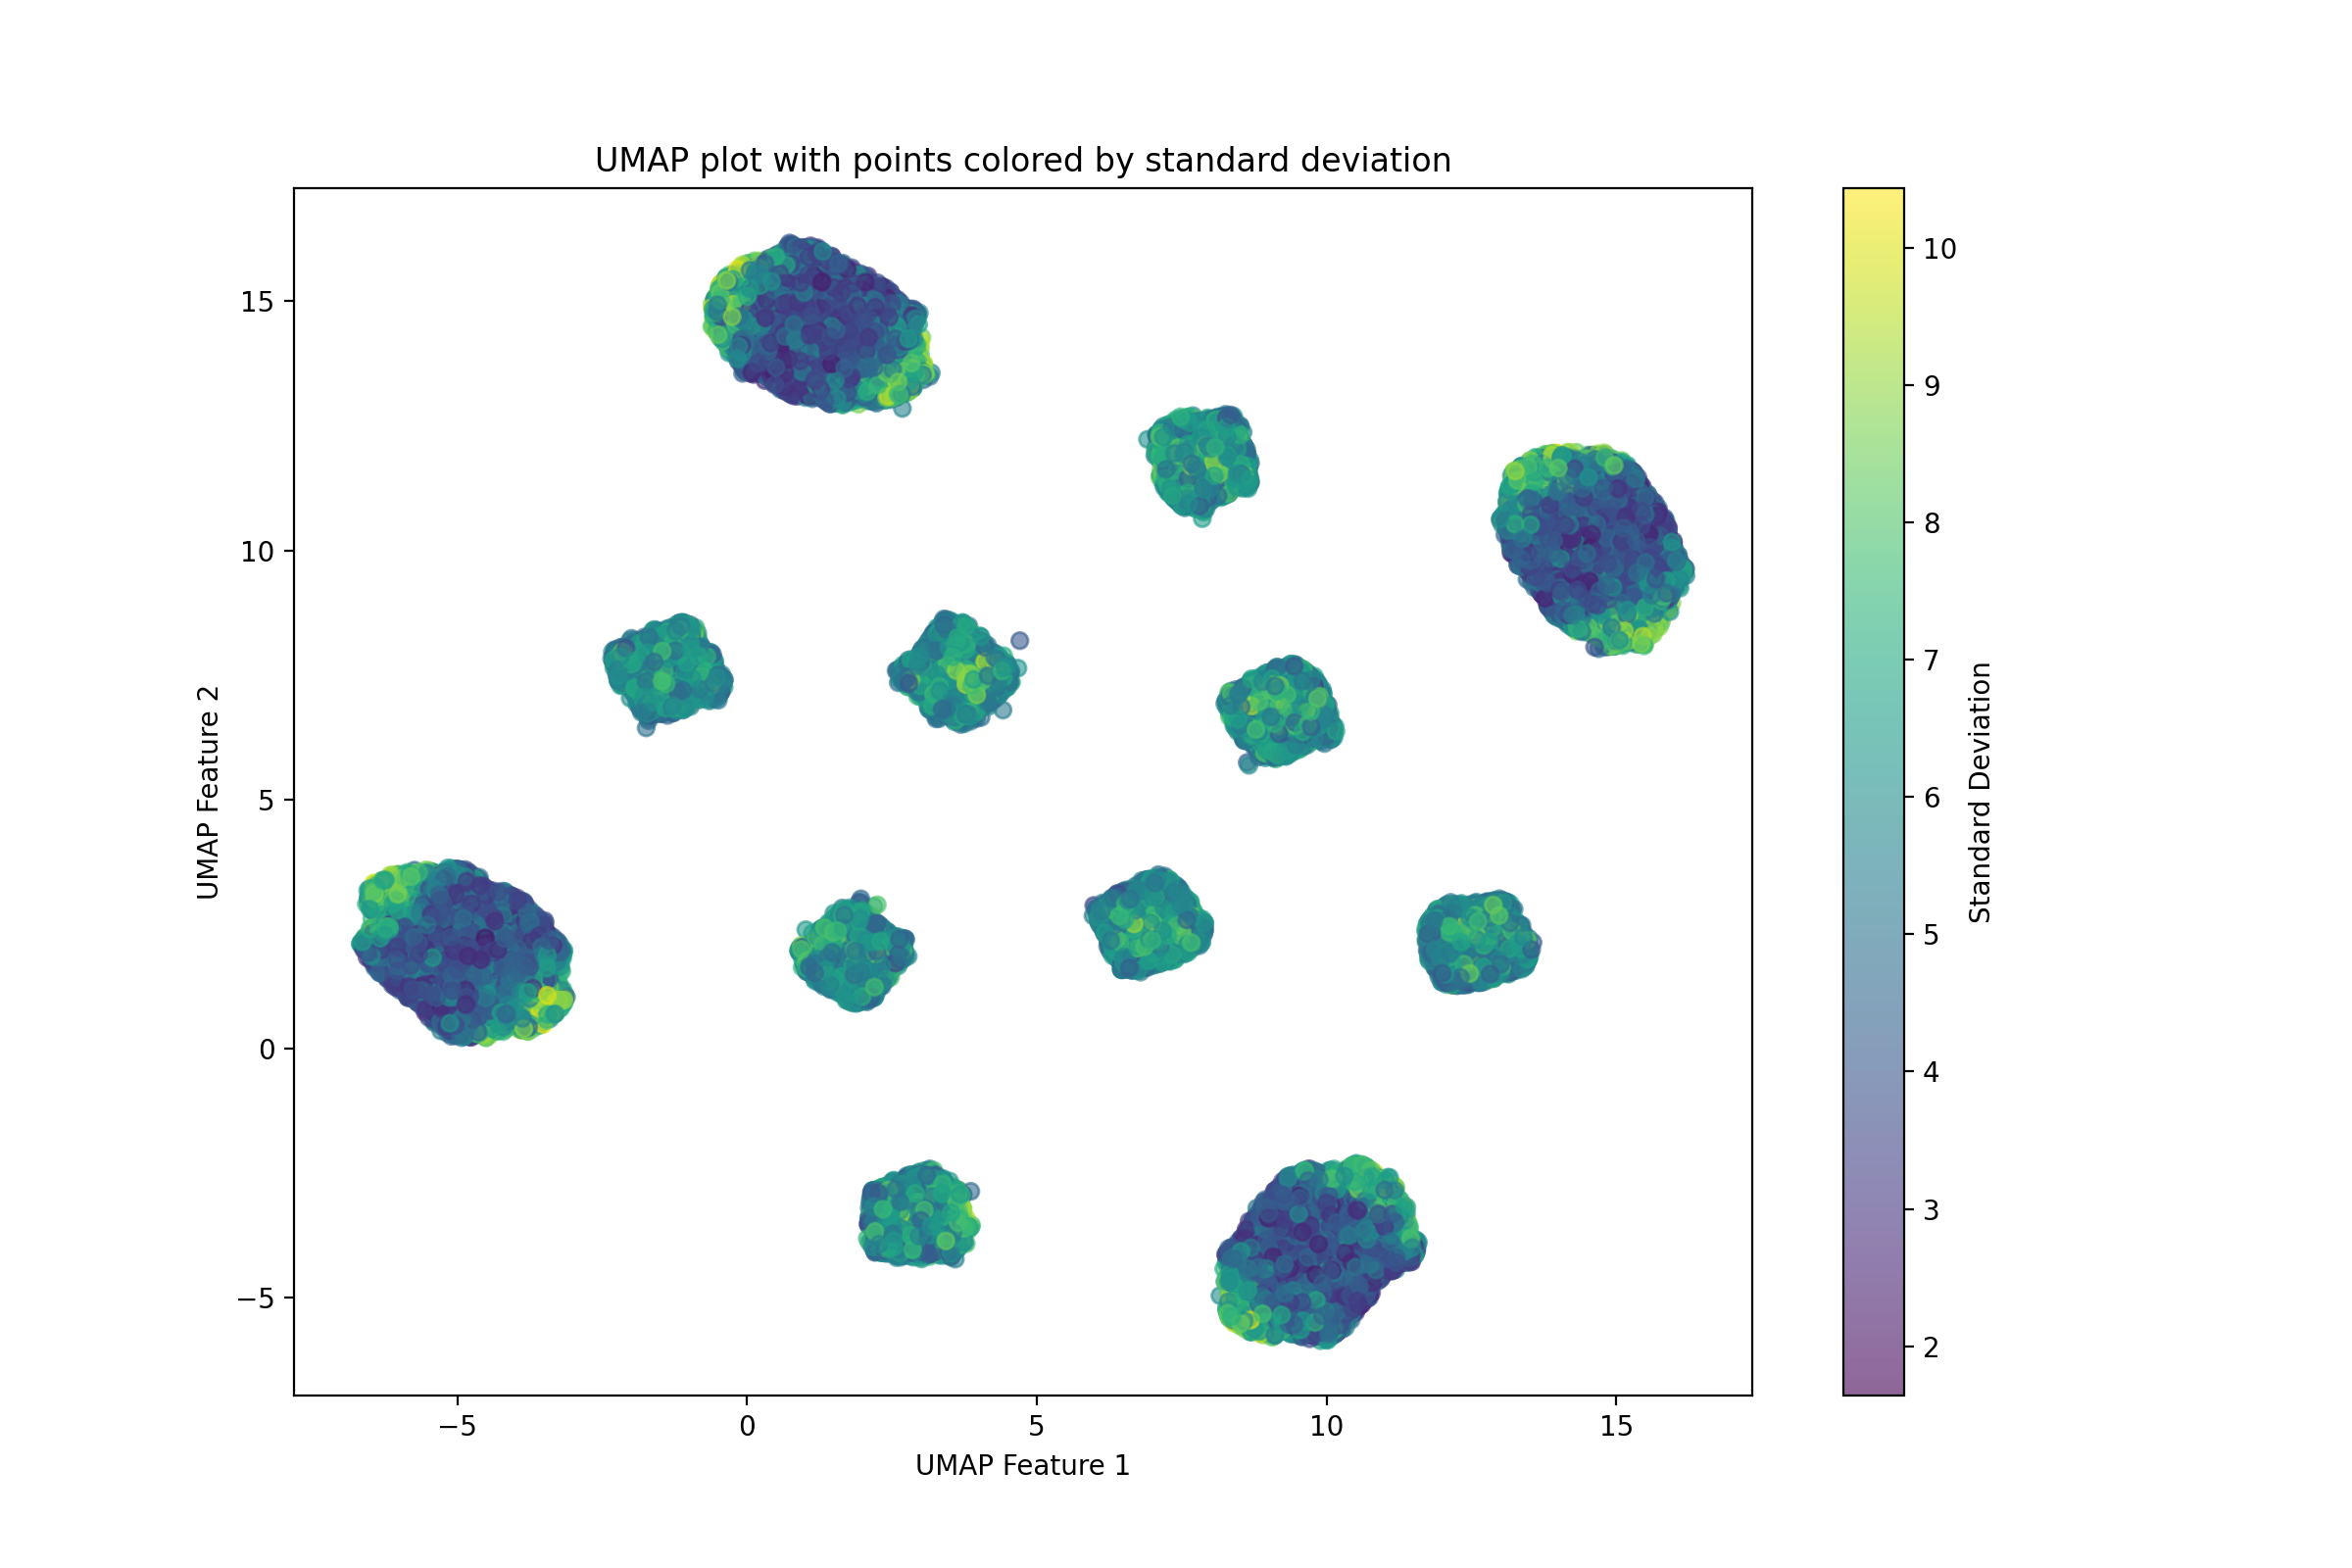

In [38]:
# Assuming `X_test` and `Y_test` are pandas DataFrames and `predicted_variances` is a numpy array

# Replace inf/-inf with NaN and then drop or impute NaN values for both X_test and Y_test
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
Y_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Assuming you want to impute NaN values, do it for both
X_test = X_test.fillna(X_test.mean())
Y_test = Y_test.fillna(Y_test.mean())

# Combine X_test and Y_test into a single DataFrame
combined_data = pd.concat([X_test, Y_test], axis=1)

# Normalize your features to ensure they don't contain too large values
scaler = MinMaxScaler()
combined_data_scaled = scaler.fit_transform(combined_data)

# Combine the scaled features into one DataFrame for UMAP
umap_features = pd.DataFrame(combined_data_scaled, columns=combined_data.columns)

# Initialize UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)

# Fit and transform the features
embedding = reducer.fit_transform(umap_features)

# Ensure no infinite values in predicted_variances before calculating the standard deviation
predicted_variances = np.where(np.isfinite(predicted_variances), predicted_variances, np.nan)
predicted_variances = np.nan_to_num(predicted_variances, nan=np.nanmean(predicted_variances))
predicted_std = np.sqrt(predicted_variances)

# Add standard deviation to the UMAP features for coloring the plot
umap_features['std_dev'] = predicted_std

# Now, let's create the plot using UMAP results
plt.figure(figsize=(12,8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                      c=umap_features['std_dev'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Standard Deviation')
plt.title('UMAP plot with points colored by standard deviation')
plt.xlabel('UMAP Feature 1')
plt.ylabel('UMAP Feature 2')
plt.show()
